--- Bước 1: Đọc Dữ liệu ---
Đã đọc thành công file: dataset.csv
Kích thước dữ liệu ban đầu: (10000, 17)

--- Bước 1.1: Trực quan hóa Giá trị Thiếu ---
Không có giá trị thiếu trong dữ liệu ban đầu.

--- Bước 2: Loại bỏ Cột Không cần thiết ---
Đã loại bỏ các cột: Defect Density, Productivity, Schedule, Project ID
Kích thước dữ liệu sau khi loại bỏ cột: (10000, 13)

--- Bước 3: Tách Biến Mục tiêu và Đặc trưng ---
Đã tách biến mục tiêu 'Effort (person-hours)'.
Kích thước X ban đầu: (10000, 12)
Kích thước y ban đầu: (10000,)
Kiểm tra các cột trong X: ['LOC', 'FP', 'UCP', 'Development Time (months)', 'Team Size', 'Project Type', 'Language Type', 'Primary Programming Language', 'Count Approach', 'Application Group', 'Application Type', 'Development Type']

--- Bước 4: Chia Dữ liệu Train/Test (TRƯỚC KHI XỬ LÝ) ---
Đã chia dữ liệu: 8000 huấn luyện, 2000 kiểm thử.

--- Bước 4.1: Trực quan hóa Dữ liệu Huấn luyện (X_train) TRƯỚC KHI XỬ LÝ ---
Trực quan hóa số lượng các hạng mục trong cột phân loại

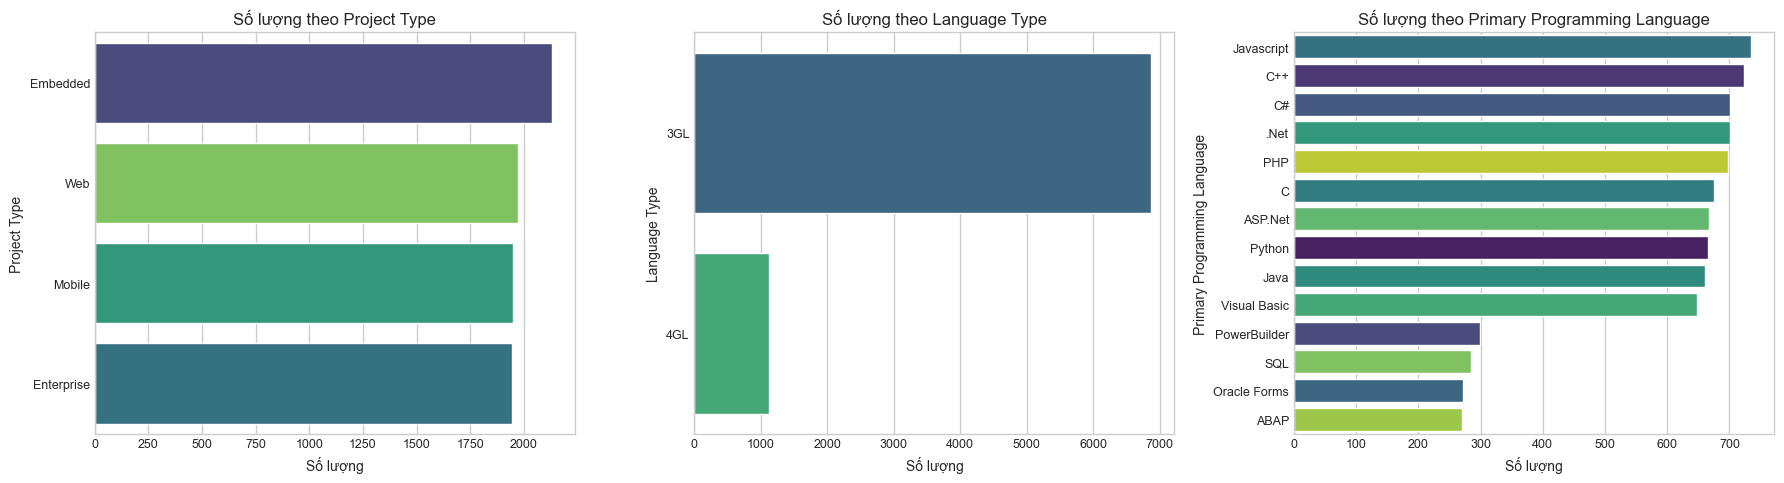


Trực quan hóa ma trận tương quan giữa các cột số:


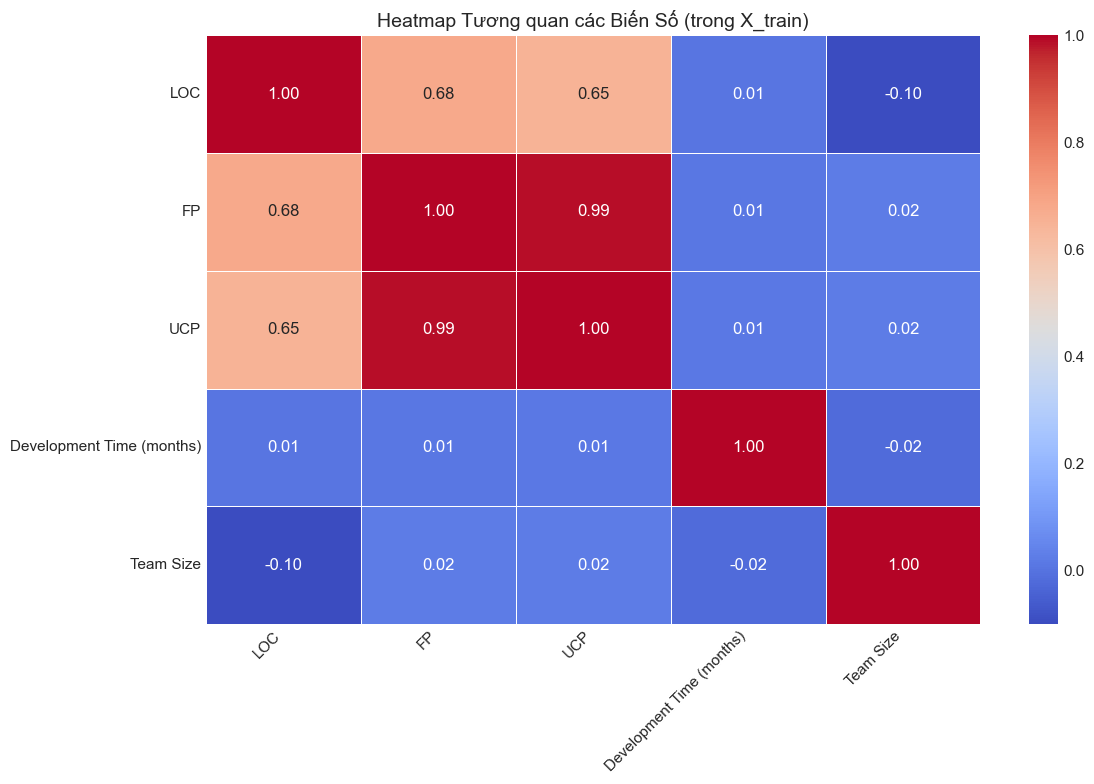


Trực quan hóa phân phối các biến số quan trọng (TRƯỚC xử lý):


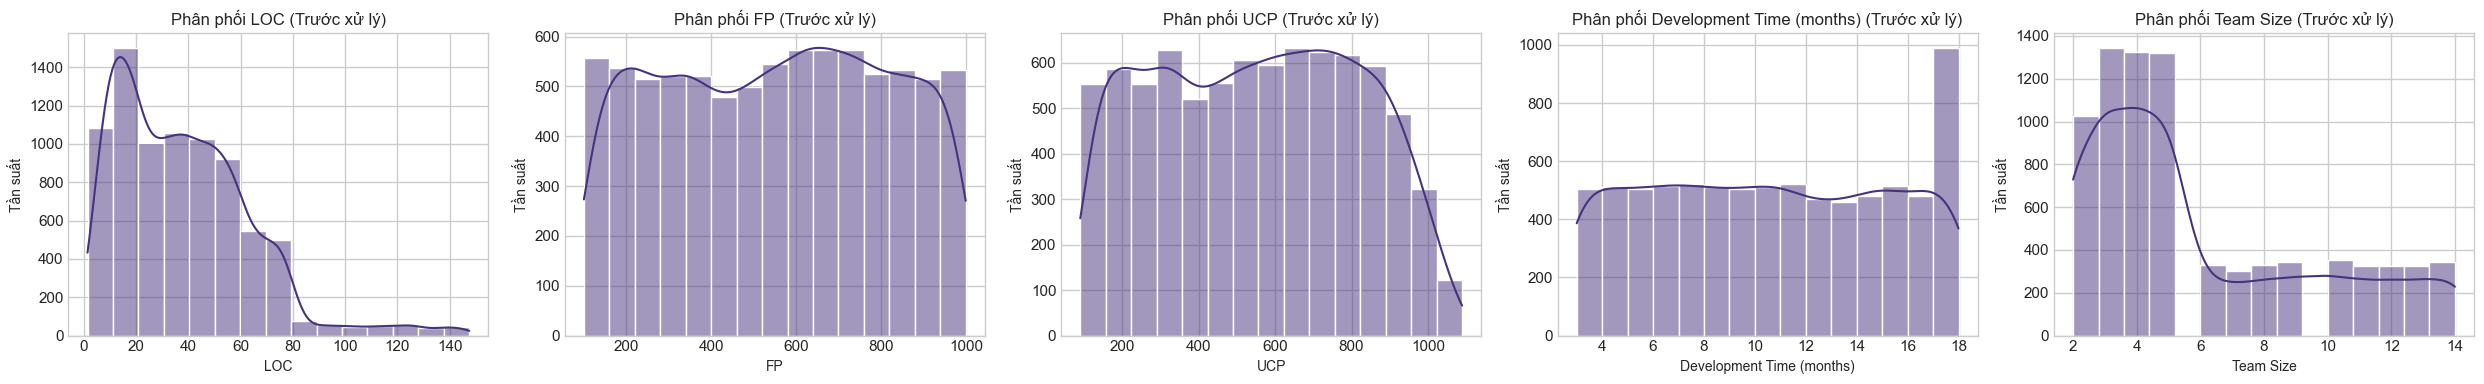


--- Bước 5: Áp dụng Quy trình Tiền xử lý Chuẩn (Fit trên Train, Transform trên Train/Test) ---
Sử dụng RobustScaler cho dữ liệu số (ít bị ảnh hưởng bởi outlier).
Bắt đầu fit preprocessor trên X_train...
Transform X_train và X_test...
Số lượng đặc trưng sau khi xử lý: 38
Đã hoàn thành tiền xử lý với RobustScaler.
Kích thước X_train_processed: (8000, 38)
Kích thước X_test_processed: (2000, 38)

--- Bước 5.5: Trực quan hóa Phân phối các Biến Số (SAU xử lý bằng RobustScaler) ---


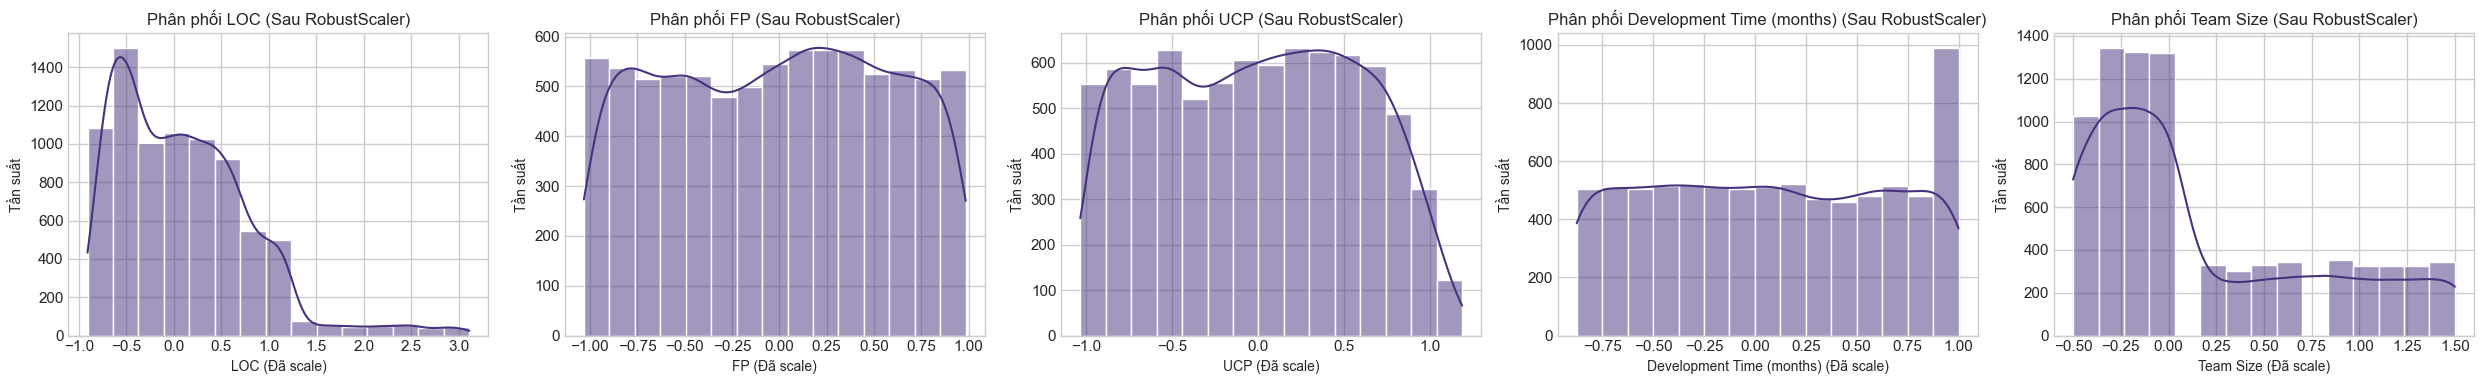


--- Bước 6: Chuẩn bị Lưu trữ ---
Đối tượng ColumnTransformer 'preprocessor' (dùng RobustScaler) đã fit và sẵn sàng để lưu.
Danh sách tên đặc trưng sau xử lý 'feature_names_out' đã sẵn sàng để lưu.

--- Hoàn thành(Sử dụng RobustScaler) ---


In [42]:
# -*- coding: utf-8 -*-
"""
Mục tiêu:
1. Đọc dữ liệu, loại bỏ cột, trực quan hóa giá trị thiếu.
2. Tách biến mục tiêu (y) và đặc trưng (X).
3. Chia dữ liệu thành tập huấn luyện và kiểm thử TRƯỚC KHI xử lý.
4. Trực quan hóa dữ liệu huấn luyện (phân phối, tương quan, counts).
5. Áp dụng quy trình tiền xử lý chuẩn dùng ColumnTransformer:
    - Sử dụng RobustScaler cho cột số để giảm ảnh hưởng outlier.
    - Fit các bộ xử lý CHỈ trên tập huấn luyện (X_train).
    - Transform cả tập huấn luyện (X_train) và tập kiểm thử (X_test).
6. Trực quan hóa dữ liệu số sau khi chuẩn hóa bằng RobustScaler.
7. Chuẩn bị dữ liệu X_train_processed, X_test_processed, y_train, y_test.

Thư viện sử dụng: pandas, numpy, sklearn, matplotlib, seaborn
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# *** THAY ĐỔI: Import RobustScaler thay vì StandardScaler ***
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

# --- Cấu hình cơ bản ---
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# --- Định nghĩa các Hàm --- # (Giữ nguyên các hàm load_data, v.v. nếu đã định nghĩa trước)

# --- 1. Đọc Dữ liệu ---
print("--- Bước 1: Đọc Dữ liệu ---")
file_path = 'dataset.csv' # !!! THAY ĐƯỜNG DẪN FILE CỦA BẠN !!!
try:
    df = pd.read_csv(file_path)
    print(f"Đã đọc thành công file: {file_path}")
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file '{file_path}'. Sử dụng dữ liệu mẫu.")
    # Tạo DataFrame mẫu (giống như trước)
    data = {
        'Project ID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'LOC': [5000, 12000, 8500, 20000, 6000, 15000, 9500, 25000, 7000, 18000, 10000, 22000],
        'FP': [50, 120, 85, 200, 60, 150, 95, 250, 70, 180, 100, 220],
        'UCP': [45, 110, 75, 180, 55, 140, 85, 230, 65, 160, 90, 200],
        'Effort (person-hours)': [1000, 2500, 1800, 4000, 1200, 3000, 2000, 5000, 1500, 3600, 2100, 4500],
        'Development Time (months)': [6, 10, 8, 12, 7, 11, 9, 14, 7, 12, 9, 13],
        'Team Size': [5, 8, 6, 10, 5, 9, 7, 12, 6, 10, 7, 11],
        'Project Type': ['New', 'Enhancement', 'New', 'New', 'Maintenance', 'Enhancement', 'New', 'New', 'Maintenance', 'Enhancement', 'New', 'New'],
        'Language Type': ['OO', 'Procedural', 'OO', 'OO', 'OO', 'Procedural', 'OO', 'OO', 'OO', 'Procedural', 'OO', 'OO'],
        'Primary Programming Language': ['Java', 'C', 'Python', 'Java', 'Java', 'C', 'Python', 'Java', 'Java', 'C', 'Python', 'Java'],
        'Count Approach': ['Manual', 'Tool', 'Manual', 'Tool', 'Manual', 'Tool', 'Manual', 'Tool', 'Manual', 'Tool', 'Manual', 'Tool'],
        'Application Group': ['Business', 'System', 'Business', 'Business', 'Business', 'System', 'Business', 'Business', 'Business', 'System', 'Business', 'Business'],
        'Application Type': ['Web', 'Embedded', 'Web', 'Desktop', 'Web', 'Embedded', 'Web', 'Desktop', 'Web', 'Embedded', 'Web', 'Desktop'],
        'Development Type': ['Internal', 'Outsource', 'Internal', 'Internal', 'Internal', 'Outsource', 'Internal', 'Internal', 'Internal', 'Outsource', 'Internal', 'Internal'],
        'Defect Density': [0.5, 0.3, 0.4, 0.2, 0.6, 0.35, 0.45, 0.25, 0.55, 0.32, 0.42, 0.28],
        'Productivity': [5, 4.8, 4.7, 5.0, 4.5, 4.7, 4.6, 4.9, 4.6, 4.8, 4.7, 4.9],
        'Schedule': [1.0, 0.9, 1.1, 1.0, 0.95, 1.05, 1.0, 0.98, 1.02, 1.0, 1.0, 0.99]
    }
    df = pd.DataFrame(data)
    # Thêm giá trị thiếu vào dữ liệu mẫu
    df.loc[2, 'LOC'] = np.nan; df.loc[5, 'FP'] = np.nan; df.loc[8, 'Project Type'] = np.nan; df.loc[1, 'Team Size'] = np.nan; df.loc[10, 'UCP'] = np.nan

print("Kích thước dữ liệu ban đầu:", df.shape)

# --- 1.1 Trực quan hóa Giá trị Thiếu ---
print("\n--- Bước 1.1: Trực quan hóa Giá trị Thiếu ---")
if df.isnull().sum().sum() > 0:
    plt.figure(figsize=(12, 7))
    sns.heatmap(df.isnull(), cbar=True, cmap='viridis', yticklabels=False)
    plt.title('Heatmap Phân bố Giá trị Thiếu (Trước xử lý)', fontsize=14)
    plt.show()
else:
    print("Không có giá trị thiếu trong dữ liệu ban đầu.")

# --- 2. Loại bỏ Cột Không cần thiết ---
print("\n--- Bước 2: Loại bỏ Cột Không cần thiết ---")
target_col = 'Effort (person-hours)'
id_col = 'Project ID'
# *** QUAN TRỌNG: Xem xét lại các cột cần loại bỏ dựa trên phân tích leakage ***
cols_to_drop_initial = ['Defect Density', 'Productivity', 'Schedule']
if id_col in df.columns:
    cols_to_drop_initial.append(id_col)

existing_cols_to_drop = [col for col in cols_to_drop_initial if col in df.columns]
if existing_cols_to_drop:
    df_cleaned = df.drop(columns=existing_cols_to_drop)
    print(f"Đã loại bỏ các cột: {', '.join(existing_cols_to_drop)}")
else:
    df_cleaned = df.copy()
print("Kích thước dữ liệu sau khi loại bỏ cột:", df_cleaned.shape)

# --- 3. Tách Biến Mục tiêu (y) và Đặc trưng (X) ---
print("\n--- Bước 3: Tách Biến Mục tiêu và Đặc trưng ---")
if target_col not in df_cleaned.columns:
    raise ValueError(f"LỖI: Cột mục tiêu '{target_col}' không tồn tại!")
y = df_cleaned[target_col]
X = df_cleaned.drop(columns=[target_col])
print(f"Đã tách biến mục tiêu '{target_col}'.")
print("Kích thước X ban đầu:", X.shape)
print("Kích thước y ban đầu:", y.shape)
print("Kiểm tra các cột trong X:", X.columns.tolist())

# --- 4. Chia Dữ liệu Train/Test TRƯỚC KHI Xử lý ---
print("\n--- Bước 4: Chia Dữ liệu Train/Test (TRƯỚC KHI XỬ LÝ) ---")
test_set_size = 0.20
random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_set_size, random_state=random_seed
)
print(f"Đã chia dữ liệu: {X_train.shape[0]} huấn luyện, {X_test.shape[0]} kiểm thử.")

# --- 4.1 Trực quan hóa Dữ liệu Huấn luyện (X_train) ---
print("\n--- Bước 4.1: Trực quan hóa Dữ liệu Huấn luyện (X_train) TRƯỚC KHI XỬ LÝ ---")
# Xác định lại các loại cột từ X_train
numerical_features_train = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features_train = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# 4.1.1 Biểu đồ đếm
print("Trực quan hóa số lượng các hạng mục trong cột phân loại (Top 3):")
n_cat_plots = min(len(categorical_features_train), 3)
if n_cat_plots > 0:
    plt.figure(figsize=(6 * n_cat_plots, 5))
    for i, col in enumerate(categorical_features_train[:n_cat_plots]):
        if not X_train[col].empty:
            plt.subplot(1, n_cat_plots, i + 1)
            sns.countplot(y=X_train[col], order=X_train[col].value_counts().index, hue=X_train[col], palette='viridis', legend=False)
            plt.title(f'Số lượng theo {col}', fontsize=12); plt.xlabel('Số lượng', fontsize=10); plt.ylabel(col, fontsize=10)
            plt.xticks(fontsize=9); plt.yticks(fontsize=9)
        else: print(f"Cột {col} không có dữ liệu.")
    plt.tight_layout(); plt.show()
else: print("Không có cột phân loại để vẽ.")

# 4.1.2 Heatmap Tương quan (*** PHONG CÁCH EDA ***)
print("\nTrực quan hóa ma trận tương quan giữa các cột số:")
if numerical_features_train:
    X_train_num_imputed_temp = X_train[numerical_features_train].copy()
    # Xử lý giá trị thiếu tạm thời chỉ để tính tương quan
    temp_imputer = SimpleImputer(strategy='median')
    X_train_num_imputed_temp[:] = temp_imputer.fit_transform(X_train_num_imputed_temp)

    correlation_matrix = X_train_num_imputed_temp.corr()

    # *** BẮT ĐẦU PHẦN HEATMAP THEO PHONG CÁCH EDA ***
    plt.figure(figsize=(12, 8)) # Kích thước giống EDA
    sns.heatmap(correlation_matrix,
                annot=True,          # Luôn hiển thị giá trị
                cmap='coolwarm',     # Colormap giống EDA
                fmt=".2f",           # Định dạng số giống EDA
                linewidths=.5        # Đường kẻ giống EDA
               )
    # Không sử dụng mask
    plt.title('Heatmap Tương quan các Biến Số (trong X_train)', fontsize=14) # Giữ title phù hợp context, có thể chỉnh fontsize=16 nếu muốn
    plt.xticks(rotation=45, ha='right') # Giống EDA
    plt.yticks(rotation=0)              # Giống EDA
    plt.tight_layout()                  # Giống EDA
    plt.show()
    # *** KẾT THÚC PHẦN HEATMAP THEO PHONG CÁCH EDA ***

else: print("Không có cột số để vẽ heatmap.")

# 4.1.3 Phân phối (TRƯỚC xử lý)
print("\nTrực quan hóa phân phối các biến số quan trọng (TRƯỚC xử lý):")
cols_to_plot_dist = [col for col in ['LOC', 'FP', 'UCP', 'Development Time (months)', 'Team Size'] if col in numerical_features_train]
if cols_to_plot_dist:
    n_dist_plots = len(cols_to_plot_dist)
    plt.figure(figsize=(5 * n_dist_plots, 4))
    for i, col in enumerate(cols_to_plot_dist):
        plt.subplot(1, n_dist_plots, i + 1)
        sns.histplot(X_train[col].dropna(), kde=True, bins=15)
        plt.title(f'Phân phối {col} (Trước xử lý)', fontsize=12)
        plt.xlabel(col, fontsize=10); plt.ylabel('Tần suất', fontsize=10)
    plt.tight_layout(); plt.show()
else: print("Không tìm thấy cột số tiêu biểu để vẽ phân phối.")


# --- 5. Định nghĩa và Áp dụng Quy trình Tiền xử lý Chuẩn ---
print("\n--- Bước 5: Áp dụng Quy trình Tiền xử lý Chuẩn (Fit trên Train, Transform trên Train/Test) ---")

# 5.1 Tạo các pipeline xử lý cho từng loại cột
print("Sử dụng RobustScaler cho dữ liệu số (ít bị ảnh hưởng bởi outlier).")
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

# 5.2 Tạo ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features_train),
        ('cat', categorical_pipeline, categorical_features_train)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# 5.3 Fit preprocessor CHỈ trên X_train và Transform cả X_train, X_test
print("Bắt đầu fit preprocessor trên X_train...")
preprocessor.fit(X_train)
print("Transform X_train và X_test...")
X_train_processed_np = preprocessor.transform(X_train)
X_test_processed_np = preprocessor.transform(X_test)

# 5.4 Lấy tên cột sau khi xử lý
try:
    feature_names_out = preprocessor.get_feature_names_out()
    print(f"Số lượng đặc trưng sau khi xử lý: {len(feature_names_out)}")
except Exception as e:
    print(f"Lỗi khi lấy tên đặc trưng: {e}. Sử dụng tên mặc định.")
    feature_names_out = [f'feature_{i}' for i in range(X_train_processed_np.shape[1])]

# Chuyển đổi thành DataFrame
X_train_processed = pd.DataFrame(X_train_processed_np, columns=feature_names_out, index=X_train.index)
X_test_processed = pd.DataFrame(X_test_processed_np, columns=feature_names_out, index=X_test.index)

print("Đã hoàn thành tiền xử lý với RobustScaler.")
print("Kích thước X_train_processed:", X_train_processed.shape)
print("Kích thước X_test_processed:", X_test_processed.shape)

# --- 5.5 Trực quan hóa Dữ liệu Số (SAU xử lý bằng RobustScaler) ---
print("\n--- Bước 5.5: Trực quan hóa Phân phối các Biến Số (SAU xử lý bằng RobustScaler) ---")
# Xác định tên các cột số sau khi đã xử lý
processed_num_cols_to_plot = []
if 'cols_to_plot_dist' in globals():
    for processed_col_name in feature_names_out:
         if '__' in processed_col_name:
              original_name = processed_col_name.split('__')[-1]
              if original_name in cols_to_plot_dist:
                   processed_num_cols_to_plot.append(processed_col_name)
         elif processed_col_name in cols_to_plot_dist and processed_col_name in numerical_features_train:
              processed_num_cols_to_plot.append(processed_col_name)

if processed_num_cols_to_plot:
    n_processed_plots = len(processed_num_cols_to_plot)
    plt.figure(figsize=(5 * n_processed_plots, 4))
    for i, col_name in enumerate(processed_num_cols_to_plot):
        plt.subplot(1, n_processed_plots, i + 1)
        sns.histplot(X_train_processed[col_name], kde=True, bins=15)
        original_col_name = col_name.split('__')[-1] if '__' in col_name else col_name
        plt.title(f'Phân phối {original_col_name} (Sau RobustScaler)', fontsize=12)
        plt.xlabel(f'{original_col_name} (Đã scale)', fontsize=10)
        plt.ylabel('Tần suất', fontsize=10)
    plt.tight_layout()
    plt.show()
else:
    print("Không tìm thấy các cột số đã xử lý để vẽ phân phối (kiểm tra lại logic xác định tên cột).")


# --- 6. Chuẩn bị Lưu trữ (Tùy chọn ở bước này) ---
print("\n--- Bước 6: Chuẩn bị Lưu trữ ---")
# joblib.dump(preprocessor, 'preprocessor_robust.joblib')
# joblib.dump(list(feature_names_out), 'feature_names_robust.joblib')
print("Đối tượng ColumnTransformer 'preprocessor' (dùng RobustScaler) đã fit và sẵn sàng để lưu.")
print("Danh sách tên đặc trưng sau xử lý 'feature_names_out' đã sẵn sàng để lưu.")


print("\n--- Hoàn thành(Sử dụng RobustScaler) ---")

--- Bước 1: Huấn luyện Mô hình Linear Regression ---
Bắt đầu huấn luyện Linear Regression...
Đã huấn luyện xong mô hình Linear Regression.

--- Bước 2: Dự đoán trên Tập Kiểm thử Đã Xử lý ---
Đã thực hiện dự đoán trên X_test_processed.

--- Bước 3: Đánh giá Hiệu suất Mô hình ---
Mean Absolute Error (MAE): 1943.18 person-hours
Root Mean Squared Error (RMSE): 2678.59 person-hours
R² Score: 0.8901
Đã lưu kết quả MAE, RMSE, R² vào các biến mae_linear, rmse_linear, r2_linear.

--- Bước 4: Trực quan hóa Kết quả ---


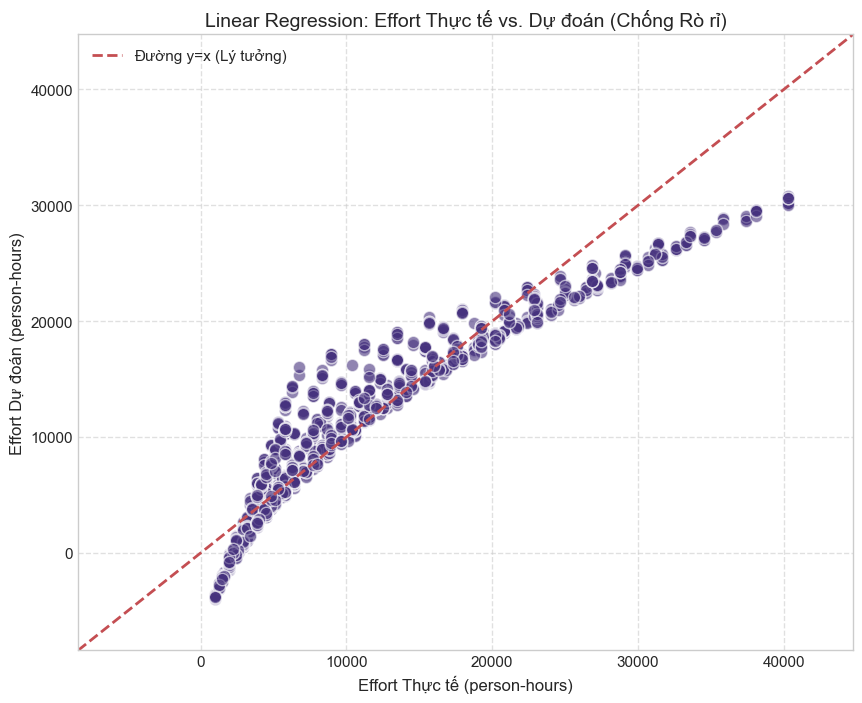

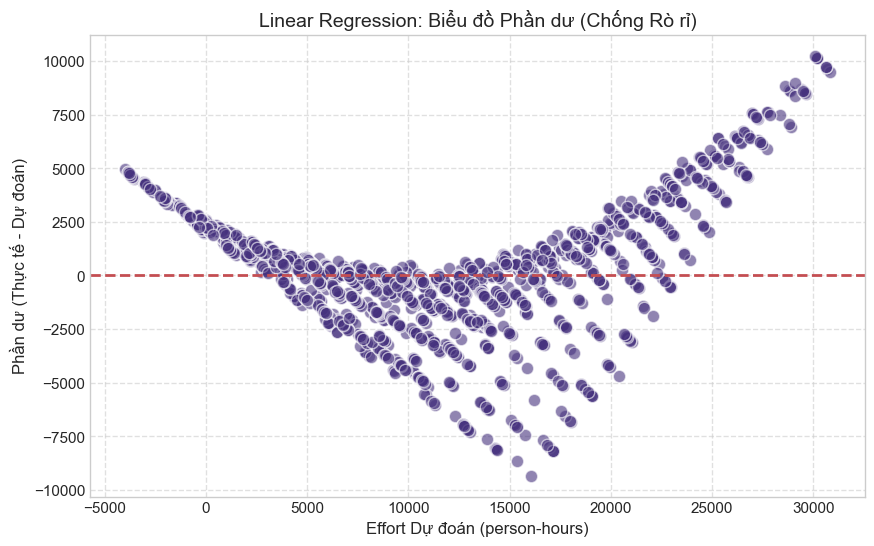

In [43]:
# -*- coding: utf-8 -*-
"""
Mục tiêu:
1. Huấn luyện mô hình Linear Regression trên tập huấn luyện đã xử lý.
2. Dự đoán effort trên tập kiểm thử đã xử lý.
3. Tính toán và lưu các chỉ số đánh giá (MAE, RMSE, R²).
4. Trực quan hóa kết quả (Scatter plot thực tế vs dự đoán, Residual plot).

Thư viện sử dụng: scikit-learn, matplotlib, seaborn, numpy
"""

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# --- Quan trọng: Giả định các biến sau đã tồn tại từ cell Prompt 1 (chống rò rỉ) ---
# X_train_processed: Dữ liệu huấn luyện đặc trưng đã qua ColumnTransformer
# X_test_processed: Dữ liệu kiểm thử đặc trưng đã qua ColumnTransformer
# y_train: Dữ liệu huấn luyện mục tiêu
# y_test: Dữ liệu kiểm thử mục tiêu
# ---------------------------------------------------------------------------

# Kiểm tra sự tồn tại của biến (đề phòng)
required_vars_p2_leakproof = ['X_train_processed', 'X_test_processed', 'y_train', 'y_test']
if not all(var in globals() for var in required_vars_p2_leakproof):
    raise NameError("LỖI: Một hoặc nhiều biến (X_train_processed, X_test_processed, y_train, y_test) không tồn tại. Hãy chạy lại cell Prompt 1 (chống rò rỉ) trước.")

print("--- Bước 1: Huấn luyện Mô hình Linear Regression ---")

# Khởi tạo mô hình
# n_jobs=-1 để sử dụng tất cả CPU cores nếu có thể (hữu ích với dữ liệu lớn)
linear_model = LinearRegression(n_jobs=-1)

# Huấn luyện mô hình trên dữ liệu huấn luyện ĐÃ XỬ LÝ CHUẨN
print("Bắt đầu huấn luyện Linear Regression...")
linear_model.fit(X_train_processed, y_train)
print("Đã huấn luyện xong mô hình Linear Regression.")

# --- Bước 2: Dự đoán Effort trên Tập Kiểm thử ĐÃ XỬ LÝ ---
print("\n--- Bước 2: Dự đoán trên Tập Kiểm thử Đã Xử lý ---")
y_pred_linear = linear_model.predict(X_test_processed)
print("Đã thực hiện dự đoán trên X_test_processed.")

# --- Bước 3: Đánh giá Mô hình và Lưu Kết quả ---
print("\n--- Bước 3: Đánh giá Hiệu suất Mô hình ---")

# Tính toán các chỉ số
# Lưu kết quả vào biến để có thể dùng so sánh ở các prompt sau
mae_linear = mean_absolute_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Mean Absolute Error (MAE): {mae_linear:.2f} person-hours")
print(f"Root Mean Squared Error (RMSE): {rmse_linear:.2f} person-hours")
print(f"R² Score: {r2_linear:.4f}")
print("Đã lưu kết quả MAE, RMSE, R² vào các biến mae_linear, rmse_linear, r2_linear.")

# --- Bước 4: Trực quan hóa Kết quả ---
print("\n--- Bước 4: Trực quan hóa Kết quả ---")

# 4.1. Biểu đồ Scatter Plot: Giá trị Thực tế vs. Giá trị Dự đoán
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_linear, alpha=0.6, edgecolors='w', s=80)
max_val = max(y_test.max(), y_pred_linear.max())
min_val = min(y_test.min(), y_pred_linear.min())
plot_min = min_val - (max_val - min_val) * 0.1
plot_max = max_val + (max_val - min_val) * 0.1
plt.plot([plot_min, plot_max], [plot_min, plot_max], 'r--', lw=2, label='Đường y=x (Lý tưởng)')
plt.xlabel('Effort Thực tế (person-hours)', fontsize=12)
plt.ylabel('Effort Dự đoán (person-hours)', fontsize=12)
plt.title('Linear Regression: Effort Thực tế vs. Dự đoán (Chống Rò rỉ)', fontsize=14)
plt.xlim(plot_min, plot_max)
plt.ylim(plot_min, plot_max)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 4.2. Biểu đồ Residual Plot: Giá trị Dự đoán vs. Phần dư
residuals_linear = y_test - y_pred_linear

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_linear, residuals_linear, alpha=0.6, edgecolors='w', s=80)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Effort Dự đoán (person-hours)', fontsize=12)
plt.ylabel('Phần dư (Thực tế - Dự đoán)', fontsize=12)
plt.title('Linear Regression: Biểu đồ Phần dư (Chống Rò rỉ)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


--- Bước 1: Huấn luyện Mô hình Decision Tree Regression (Đơn giản) ---
Khởi tạo DecisionTreeRegressor với max_depth=7, random_state=42.
Bắt đầu huấn luyện Decision Tree đơn giản...
Đã huấn luyện xong mô hình Decision Tree đơn giản.

--- Bước 2: Dự đoán trên Tập Kiểm thử bằng mô hình đơn giản ---
Đã thực hiện dự đoán trên X_test_processed.

--- Bước 3: Đánh giá Hiệu suất Mô hình Decision Tree (Đơn giản) trên tập Test ---
Mean Absolute Error (MAE): 303.31 person-hours
Root Mean Squared Error (RMSE): 440.50 person-hours
R² Score (trên tập test): 0.9970

So sánh với Linear Regression:
  MAE Linear: 1943.18 vs MAE Decision Tree: 303.31
  RMSE Linear: 2678.59 vs RMSE Decision Tree: 440.50
  R² Linear: 0.8901 vs R² Decision Tree: 0.9970

--- Bước 4: Trực quan hóa Kết quả ---


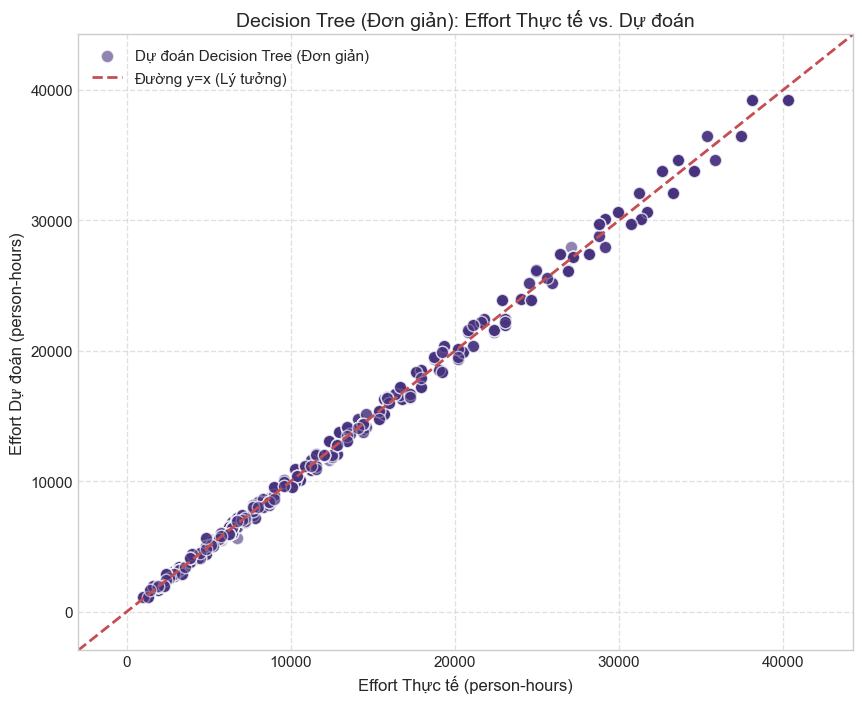

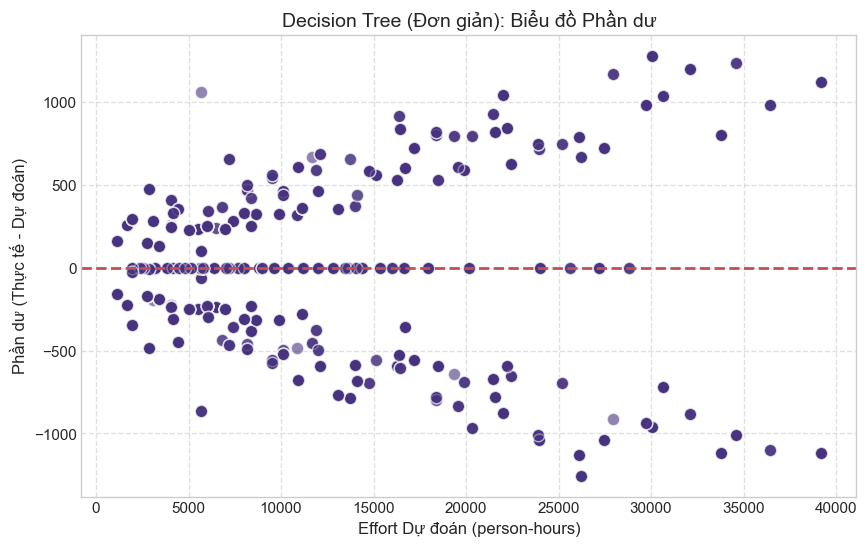


--- Hoàn thành (Mô hình Decision Tree Đơn giản) ---


In [44]:
# -*- coding: utf-8 -*-
"""
Mục tiêu:
1. Huấn luyện một mô hình Decision Tree Regressor đơn giản (không dùng GridSearchCV).
2. Dự đoán effort trên tập kiểm thử đã xử lý.
3. Tính toán các chỉ số đánh giá (MAE, RMSE, R²).
4. Trực quan hóa kết quả (Scatter plot thực tế vs dự đoán, Residual plot).

Thư viện sử dụng: scikit-learn, matplotlib, seaborn, numpy
"""

from sklearn.tree import DecisionTreeRegressor
# Bỏ GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Quan trọng: Giả định các biến sau đã tồn tại từ các cell trước ---
# X_train_processed: Dữ liệu huấn luyện đặc trưng (từ Prompt 1 chống rò rỉ)
# X_test_processed: Dữ liệu kiểm thử đặc trưng (từ Prompt 1 chống rò rỉ)
# y_train: Dữ liệu huấn luyện mục tiêu (từ Prompt 1 chống rò rỉ)
# y_test: Dữ liệu kiểm thử mục tiêu (từ Prompt 1 chống rò rỉ)
# mae_linear, rmse_linear, r2_linear: Kết quả từ mô hình Linear Regression (từ Prompt 2 chống rò rỉ)
# ---------------------------------------------------------------------------

# Kiểm tra sự tồn tại của biến (đề phòng)
required_vars_p3_simple = ['X_train_processed', 'X_test_processed', 'y_train', 'y_test',
                           'mae_linear', 'rmse_linear', 'r2_linear']
if not all(var in globals() for var in required_vars_p3_simple):
    raise NameError("LỖI: Một hoặc nhiều biến cần thiết không tồn tại. Hãy chạy lại cell Prompt 1 (chống rò rỉ) và Prompt 2 (chống rò rỉ) trước.")

print("--- Bước 1: Huấn luyện Mô hình Decision Tree Regression (Đơn giản) ---")

# 1.1. Khởi tạo mô hình Decision Tree đơn giản
# Đặt max_depth để kiểm soát độ phức tạp, ví dụ max_depth=7
# Bạn có thể thay đổi giá trị max_depth này để thử nghiệm
simple_dt_model = DecisionTreeRegressor(max_depth=7, random_state=42)
print(f"Khởi tạo DecisionTreeRegressor với max_depth={simple_dt_model.max_depth}, random_state=42.")

# 1.2. Huấn luyện mô hình trực tiếp trên dữ liệu đã xử lý
print("Bắt đầu huấn luyện Decision Tree đơn giản...")
simple_dt_model.fit(X_train_processed, y_train)
print("Đã huấn luyện xong mô hình Decision Tree đơn giản.")

# --- Bước 2: Dự đoán Effort trên Tập Kiểm thử bằng mô hình đơn giản ---
print("\n--- Bước 2: Dự đoán trên Tập Kiểm thử bằng mô hình đơn giản ---")
y_pred_dt = simple_dt_model.predict(X_test_processed) # Sử dụng mô hình đơn giản để dự đoán
print("Đã thực hiện dự đoán trên X_test_processed.")

# --- Bước 3: Đánh giá Mô hình ---
print("\n--- Bước 3: Đánh giá Hiệu suất Mô hình Decision Tree (Đơn giản) trên tập Test ---")

# Tính toán các chỉ số
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt) # R2 trên tập test

print(f"Mean Absolute Error (MAE): {mae_dt:.2f} person-hours")
print(f"Root Mean Squared Error (RMSE): {rmse_dt:.2f} person-hours")
print(f"R² Score (trên tập test): {r2_dt:.4f}")

# So sánh với Linear Regression (sử dụng biến đã lưu từ Prompt 2)
print(f"\nSo sánh với Linear Regression:")
print(f"  MAE Linear: {mae_linear:.2f} vs MAE Decision Tree: {mae_dt:.2f}")
print(f"  RMSE Linear: {rmse_linear:.2f} vs RMSE Decision Tree: {rmse_dt:.2f}")
print(f"  R² Linear: {r2_linear:.4f} vs R² Decision Tree: {r2_dt:.4f}")

# --- Bước 4: Trực quan hóa Kết quả ---
print("\n--- Bước 4: Trực quan hóa Kết quả ---")

# 4.1. Biểu đồ Scatter Plot: Giá trị Thực tế vs. Giá trị Dự đoán
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_dt, alpha=0.6, edgecolors='w', s=80, label='Dự đoán Decision Tree (Đơn giản)')
max_val = max(y_test.max(), y_pred_dt.max())
min_val = min(y_test.min(), y_pred_dt.min())
plot_min = min_val - (max_val - min_val) * 0.1
plot_max = max_val + (max_val - min_val) * 0.1
plt.plot([plot_min, plot_max], [plot_min, plot_max], 'r--', lw=2, label='Đường y=x (Lý tưởng)')
plt.xlabel('Effort Thực tế (person-hours)', fontsize=12)
plt.ylabel('Effort Dự đoán (person-hours)', fontsize=12)
plt.title('Decision Tree (Đơn giản): Effort Thực tế vs. Dự đoán', fontsize=14)
plt.xlim(plot_min, plot_max)
plt.ylim(plot_min, plot_max)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 4.2. Biểu đồ Residual Plot: Giá trị Dự đoán vs. Phần dư
residuals_dt = y_test - y_pred_dt

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_dt, residuals_dt, alpha=0.6, edgecolors='w', s=80)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Effort Dự đoán (person-hours)', fontsize=12)
plt.ylabel('Phần dư (Thực tế - Dự đoán)', fontsize=12)
plt.title('Decision Tree (Đơn giản): Biểu đồ Phần dư', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
print("\n--- Hoàn thành (Mô hình Decision Tree Đơn giản) ---")


Kích thước X_train_processed: (8000, 38)
Kích thước X_test_processed: (2000, 38)
Kích thước y_train: (8000,)
Kích thước y_test: (2000,)
--- Bước 1: Huấn luyện Mô hình Random Forest Regression (Tìm siêu tham số) ---
Không gian tham số tìm kiếm: {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5], 'max_features': ['sqrt', 'log2']}
Bắt đầu tìm kiếm tham số tốt nhất cho Random Forest bằng GridSearchCV...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Điểm MAE tốt nhất từ Cross-Validation: 1250.12
Đã tìm thấy tham số tốt nhất: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mô hình Random Forest tốt nhất đã được huấn luyện.

--- Bước 2: Dự đoán trên Tập Kiểm thử bằng mô hình tốt nhất ---
Đã thực hiện dự đoán trên X_test_processed.

--- Bước 3: Đánh giá Hiệu suất Mô hình Random Forest trên tập Test ---
Mean Absolute Error (MAE): 1210.94 person-hours

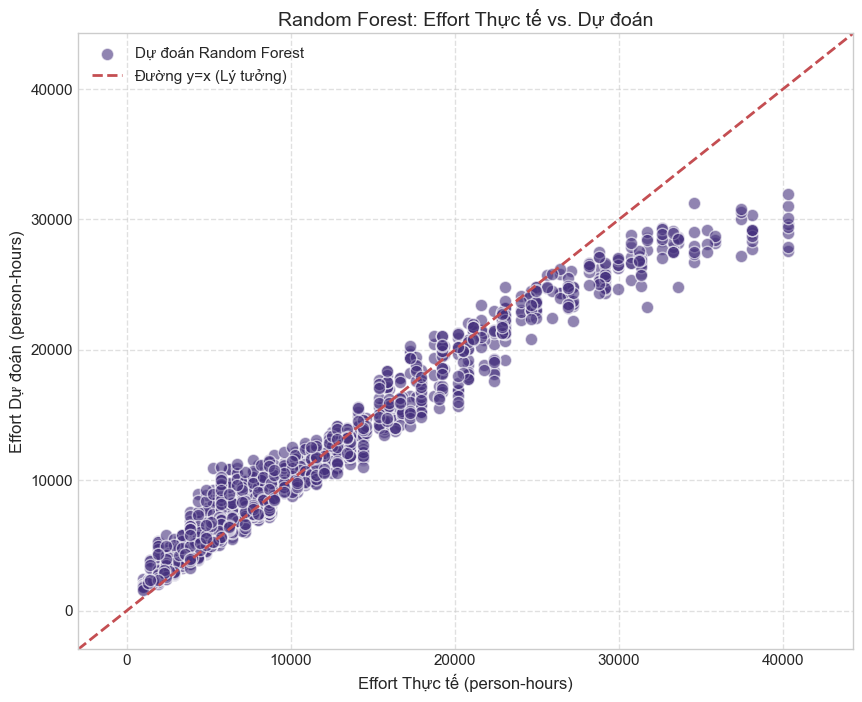

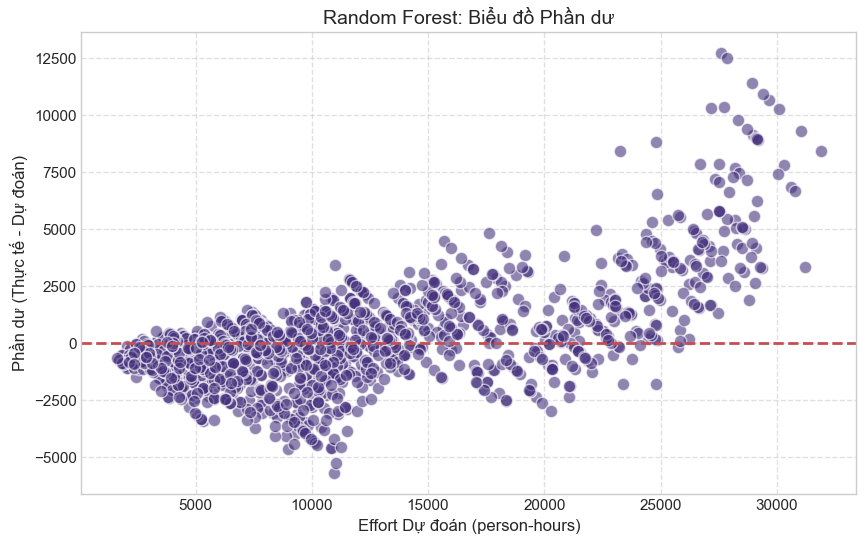


--- Bước 5: Độ quan trọng của Đặc trưng ---
Top 20 đặc trưng quan trọng nhất:
                                              Feature  Importance
4                                           Team Size    0.392112
3                           Development Time (months)    0.295252
7                                    Project Type_Web    0.054874
5                             Project Type_Enterprise    0.053564
0                                                 LOC    0.029052
2                                                 UCP    0.027519
1                                                  FP    0.026201
6                                 Project Type_Mobile    0.022227
8                                   Language Type_4GL    0.011900
27            Application Group_Real-Time Application    0.004280
22                               Count Approach_FiSMA    0.004278
26  Application Group_Mathematically Intensive App...    0.004167
25          Application Group_Infrastructure Software    0.0041

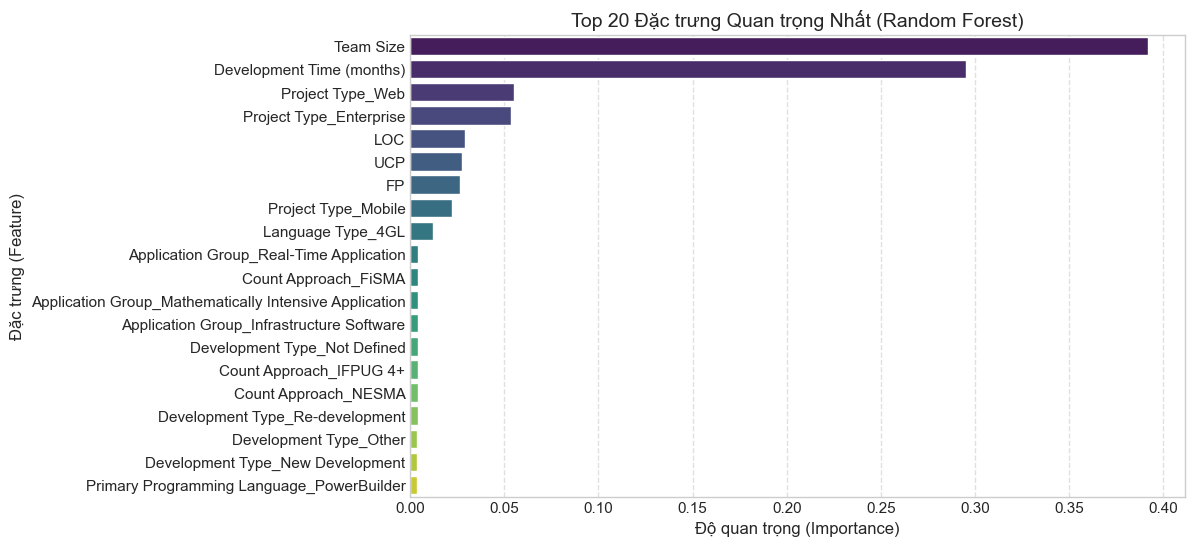


--- Hoàn thành (Random Forest) ---


In [45]:
# -*- coding: utf-8 -*-
"""
Mục tiêu:
1. Huấn luyện mô hình RandomForestRegressor, tìm siêu tham số tối ưu bằng GridSearchCV.
2. Dự đoán effort trên tập kiểm thử đã xử lý bằng mô hình tốt nhất.
3. Tính toán các chỉ số đánh giá (MAE, RMSE, R²).
4. Trực quan hóa kết quả (Scatter plot, Residual plot).
5. (Tùy chọn) Trực quan hóa độ quan trọng của đặc trưng.

Thư viện sử dụng: scikit-learn, matplotlib, seaborn, numpy, pandas
"""

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings

# Tạm thời bỏ qua FutureWarning cụ thể từ seaborn
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

# --- Quan trọng: Giả định các biến sau đã tồn tại từ các cell trước ---
# X_train_processed: Dữ liệu huấn luyện đặc trưng (từ Prompt 1 chống rò rỉ)
# X_test_processed: Dữ liệu kiểm thử đặc trưng (từ Prompt 1 chống rò rỉ)
# y_train: Dữ liệu huấn luyện mục tiêu (từ Prompt 1 chống rò rỉ)
# y_test: Dữ liệu kiểm thử mục tiêu (từ Prompt 1 chống rò rỉ)
# mae_linear, rmse_linear, r2_linear: Kết quả từ Linear Regression (Prompt 2)
# mae_dt, rmse_dt, r2_dt: Kết quả từ Decision Tree (Prompt 3)
# ---------------------------------------------------------------------------

# Kiểm tra sự tồn tại của biến (đề phòng)
required_vars_p4 = ['X_train_processed', 'X_test_processed', 'y_train', 'y_test',
                    'mae_linear', 'rmse_linear', 'r2_linear',
                    'mae_dt', 'rmse_dt', 'r2_dt']
if not all(var in globals() for var in required_vars_p4):
    raise NameError("LỖI: Một hoặc nhiều biến cần thiết không tồn tại. Hãy chạy lại cell Prompt 1, 2, 3 (chống rò rỉ) trước.")

# Thêm kiểm tra để phát hiện rò rỉ dữ liệu
if np.array_equal(X_train_processed, X_test_processed) or np.array_equal(y_train, y_test):
    raise ValueError("LỖI: Dữ liệu huấn luyện và kiểm thử giống nhau. Kiểm tra lại quy trình tách dữ liệu ở Prompt 1.")

# Kiểm tra kích thước dữ liệu
print(f"Kích thước X_train_processed: {X_train_processed.shape}")
print(f"Kích thước X_test_processed: {X_test_processed.shape}")
print(f"Kích thước y_train: {y_train.shape}")
print(f"Kích thước y_test: {y_test.shape}")

print("--- Bước 1: Huấn luyện Mô hình Random Forest Regression (Tìm siêu tham số) ---")

# 1.1. Định nghĩa không gian tham số (tinh chỉnh để cân bằng giữa hiệu suất và thời gian)
param_grid_rf = {
    'n_estimators': [100, 200],          # Tăng số cây để cải thiện độ ổn định
    'max_depth': [10, 20, None],         # Giới hạn độ sâu để tránh overfitting
    'min_samples_leaf': [1, 2, 4],       # Tăng số mẫu tối thiểu ở lá
    'min_samples_split': [2, 5],         # Tăng số mẫu tối thiểu để tách
    'max_features': ['sqrt', 'log2']     # Giới hạn số đặc trưng để giảm thời gian
}
print("Không gian tham số tìm kiếm:", param_grid_rf)

# 1.2. Khởi tạo mô hình Random Forest cơ sở
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# 1.3. Sử dụng GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                              cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)

print("Bắt đầu tìm kiếm tham số tốt nhất cho Random Forest bằng GridSearchCV...")
grid_search_rf.fit(X_train_processed, y_train)

# 1.4. Lấy ra mô hình tốt nhất
best_rf_model = grid_search_rf.best_estimator_
print(f"\nĐiểm MAE tốt nhất từ Cross-Validation: {-grid_search_rf.best_score_:.2f}")
print("Đã tìm thấy tham số tốt nhất:", grid_search_rf.best_params_)
print("Mô hình Random Forest tốt nhất đã được huấn luyện.")

# --- Bước 2: Dự đoán Effort trên Tập Kiểm thử bằng mô hình tốt nhất ---
print("\n--- Bước 2: Dự đoán trên Tập Kiểm thử bằng mô hình tốt nhất ---")
y_pred_rf = best_rf_model.predict(X_test_processed)
print("Đã thực hiện dự đoán trên X_test_processed.")

# --- Bước 3: Đánh giá Mô hình ---
print("\n--- Bước 3: Đánh giá Hiệu suất Mô hình Random Forest trên tập Test ---")

# Tính toán các chỉ số
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Kiểm tra kết quả bất thường
if mae_rf < 1.0 or rmse_rf < 1.0 or r2_rf > 0.9999:
    print("CẢNH BÁO: Kết quả MAE/RMSE quá thấp hoặc R² quá cao, có thể do rò rỉ dữ liệu hoặc lỗi dữ liệu.")
    print("Vui lòng kiểm tra lại quy trình tách dữ liệu và tiền xử lý ở Prompt 1.")

print(f"Mean Absolute Error (MAE): {mae_rf:.2f} person-hours")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f} person-hours")
print(f"R² Score (trên tập test): {r2_rf:.4f}")

# So sánh với các mô hình trước
print(f"\nSo sánh với các mô hình trước:")
print(f"  Model             | MAE      | RMSE     | R² Score")
print(f"------------------|----------|----------|----------")
print(f"  Linear Regression | {mae_linear:8.2f} | {rmse_linear:8.2f} | {r2_linear:8.4f}")
print(f"  Decision Tree     | {mae_dt:8.2f} | {rmse_dt:8.2f} | {r2_dt:8.4f}")
print(f"  Random Forest     | {mae_rf:8.2f} | {rmse_rf:8.2f} | {r2_rf:8.4f}")

# --- Bước 4: Trực quan hóa Kết quả ---
print("\n--- Bước 4: Trực quan hóa Kết quả ---")

# 4.1. Biểu đồ Scatter Plot: Giá trị Thực tế vs. Giá trị Dự đoán
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_rf, alpha=0.6, edgecolors='w', s=80, label='Dự đoán Random Forest')
max_val = max(y_test.max(), y_pred_rf.max())
min_val = min(y_test.min(), y_pred_rf.min())
plot_min = min_val - (max_val - min_val) * 0.1
plot_max = max_val + (max_val - min_val) * 0.1
plt.plot([plot_min, plot_max], [plot_min, plot_max], 'r--', lw=2, label='Đường y=x (Lý tưởng)')
plt.xlabel('Effort Thực tế (person-hours)', fontsize=12)
plt.ylabel('Effort Dự đoán (person-hours)', fontsize=12)
plt.title('Random Forest: Effort Thực tế vs. Dự đoán', fontsize=14)
plt.xlim(plot_min, plot_max)
plt.ylim(plot_min, plot_max)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 4.2. Biểu đồ Residual Plot: Giá trị Dự đoán vs. Phần dư
residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.6, edgecolors='w', s=80)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Effort Dự đoán (person-hours)', fontsize=12)
plt.ylabel('Phần dư (Thực tế - Dự đoán)', fontsize=12)
plt.title('Random Forest: Biểu đồ Phần dư', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Bước 5: Hiển thị Độ quan trọng của Đặc trưng ---
print("\n--- Bước 5: Độ quan trọng của Đặc trưng ---")

# Lấy độ quan trọng từ mô hình
importances = best_rf_model.feature_importances_

# Xử lý tên đặc trưng
if isinstance(X_train_processed, pd.DataFrame):
    feature_names = X_train_processed.columns
else:
    try:
        feature_names = feature_names_out  # Giả định từ Prompt 1
    except NameError:
        feature_names = [f'feature_{i}' for i in range(X_train_processed.shape[1])]
        print("Cảnh báo: Không tìm thấy tên đặc trưng. Sử dụng tên mặc định.")

# Tạo DataFrame cho độ quan trọng
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Hiển thị top N đặc trưng
top_n = 20
feature_importance_df_top = feature_importance_df.head(top_n)
print(f"Top {top_n} đặc trưng quan trọng nhất:")
print(feature_importance_df_top)

# Vẽ biểu đồ độ quan trọng đặc trưng
plt.figure(figsize=(10, max(6, top_n * 0.3)))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importance_df_top, palette='viridis', legend=False)
plt.title(f'Top {top_n} Đặc trưng Quan trọng Nhất (Random Forest)', fontsize=14)
plt.xlabel('Độ quan trọng (Importance)', fontsize=12)
plt.ylabel('Đặc trưng (Feature)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

print("\n--- Hoàn thành (Random Forest) ---")

--- Bước 1: Huấn luyện Mô hình XGBoost Regressor (Tham số cơ bản) ---
Khởi tạo XGBRegressor với các tham số:
  objective = 'reg:squarederror'
  n_estimators = 150
  learning_rate = 0.08
  max_depth = 6
  subsample = 0.7
  colsample_bytree = 0.7

Bắt đầu huấn luyện XGBoost...
Đã huấn luyện xong mô hình XGBoost.

--- Bước 2: Dự đoán trên Tập Kiểm thử ---
Đã thực hiện dự đoán trên X_test_processed.

--- Bước 3: Đánh giá Hiệu suất Mô hình XGBoost trên tập Test ---
Mean Absolute Error (MAE): 262.83 person-hours
Root Mean Squared Error (RMSE): 421.84 person-hours
R² Score (trên tập test): 0.9973

So sánh với các mô hình trước:
  Model             | MAE      | RMSE     | R² Score
------------------|----------|----------|----------
  Linear Regression |  1943.18 |  2678.59 |   0.8901
  Decision Tree     |   303.31 |   440.50 |   0.9970
  Random Forest     |  1210.94 |  1890.54 |   0.9452
  XGBoost           |   262.83 |   421.84 |   0.9973

--- Bước 4: Trực quan hóa Kết quả ---


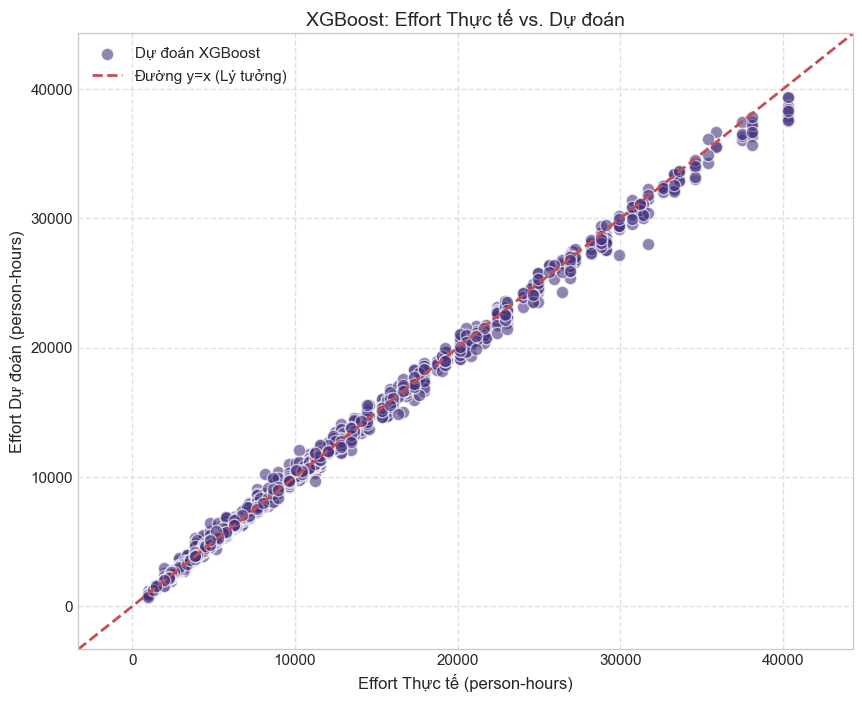

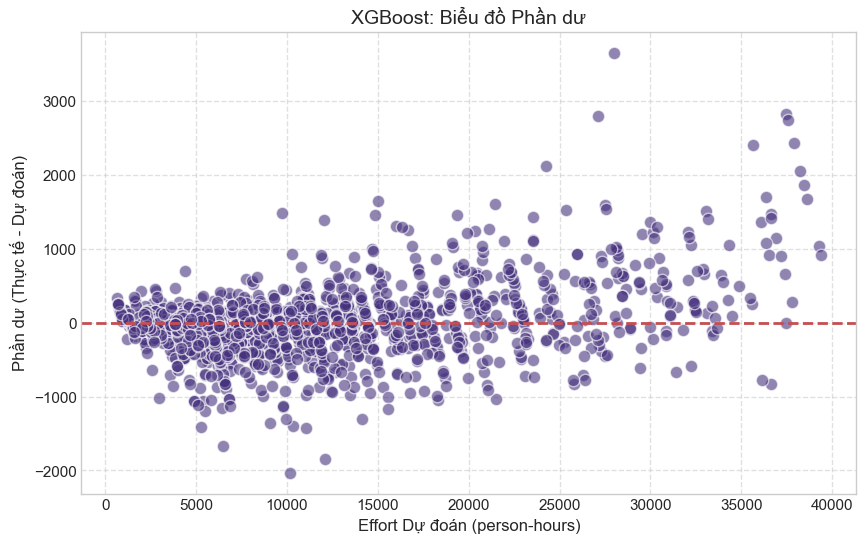


--- Bước 5 (Tùy chọn): Độ quan trọng của Đặc trưng (XGBoost) ---
Top 20 đặc trưng quan trọng nhất (XGBoost):
                                      Feature  Importance
4                                   Team Size    0.235188
3                   Development Time (months)    0.163676
5                     Project Type_Enterprise    0.148348
7                            Project Type_Web    0.127340
6                         Project Type_Mobile    0.116067
8                           Language Type_4GL    0.059407
22                       Count Approach_FiSMA    0.007541
9           Primary Programming Language_ABAP    0.007329
18  Primary Programming Language_PowerBuilder    0.007180
1                                          FP    0.006940
32        Application Type_Transaction System    0.006757
21  Primary Programming Language_Visual Basic    0.006370
15    Primary Programming Language_Javascript    0.006297
16  Primary Programming Language_Oracle Forms    0.006287
20           Primary

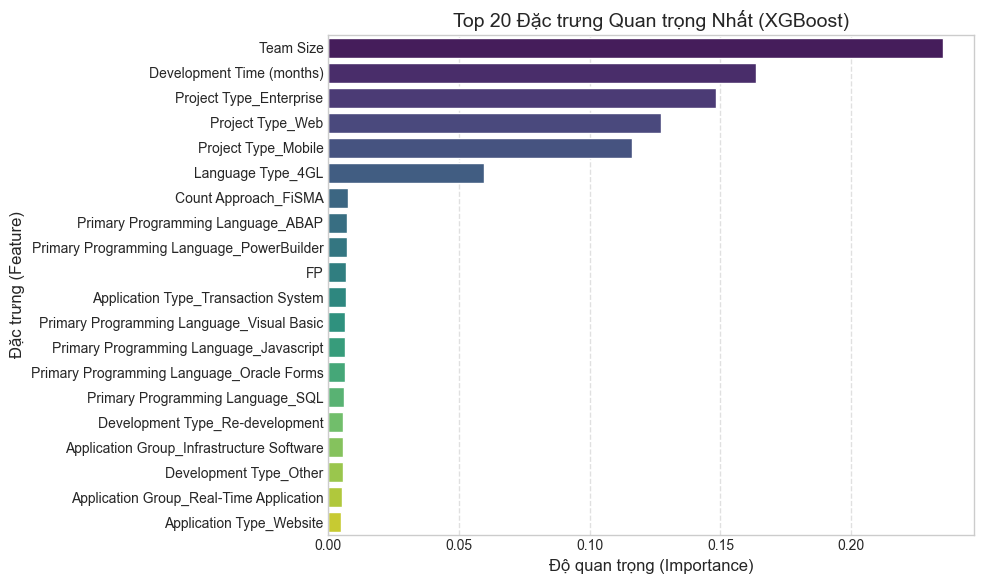


--- Hoàn thành(XGBoost) ---


In [46]:
# -*- coding: utf-8 -*-
"""
Mục tiêu:
1. Huấn luyện mô hình XGBoost Regressor với một số tham số cơ bản được tinh chỉnh.
2. Dự đoán effort trên tập kiểm thử đã xử lý.
3. Tính toán các chỉ số đánh giá (MAE, RMSE, R²).
4. Trực quan hóa kết quả (Scatter plot, Residual plot).
5. Thêm cảnh báo nếu kết quả đánh giá quá tốt (nghi ngờ rò rỉ dữ liệu).

Thư viện sử dụng: xgboost, scikit-learn, matplotlib, seaborn, numpy, pandas
"""

# --- Cài đặt Thư viện (Nếu cần) ---
# Bạn có thể cần cài đặt thư viện xgboost nếu chưa có:
# !pip install xgboost

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings # Thêm thư viện warnings

# Tạm thời bỏ qua FutureWarning cụ thể này nếu muốn
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")


# --- Quan trọng: Giả định các biến sau đã tồn tại từ các cell trước ---
# !!! LƯU Ý QUAN TRỌNG !!!
# NẾU KẾT QUẢ ĐÁNH GIÁ Ở BƯỚC 3 CHO THẤY LỖI = 0 VÀ R2 = 1.0,
# ĐIỀU NÀY HẦU NHƯ CHẮC CHẮN LÀ DO RÒ RỈ DỮ LIỆU (DATA LEAKAGE).
# BẠN CẦN QUAY LẠI PROMPT 1 (TIỀN XỬ LÝ) ĐỂ KIỂM TRA VÀ LOẠI BỎ
# CÁC ĐẶC TRƯNG GÂY RÒ RỈ (VÍ DỤ: CÁC CỘT MÀ GIÁ TRỊ CHỈ CÓ THỂ BIẾT
# SAU KHI EFFORT ĐÃ ĐƯỢC XÁC ĐỊNH).
# VIỆC SỬA CODE TRONG PROMPT NÀY SẼ KHÔNG GIẢI QUYẾT ĐƯỢC GỐC RỄ VẤN ĐỀ ĐÓ.
# ---------------------------------------------------------------------------
# X_train_processed: Dữ liệu huấn luyện đặc trưng (từ Prompt 1 chống rò rỉ)
# X_test_processed: Dữ liệu kiểm thử đặc trưng (từ Prompt 1 chống rò rỉ)
# y_train: Dữ liệu huấn luyện mục tiêu (từ Prompt 1 chống rò rỉ)
# y_test: Dữ liệu kiểm thử mục tiêu (từ Prompt 1 chống rò rỉ)
# mae_linear, rmse_linear, r2_linear: Kết quả từ Linear Regression (Prompt 2)
# mae_dt, rmse_dt, r2_dt: Kết quả từ Decision Tree (Prompt 3)
# mae_rf, rmse_rf, r2_rf: Kết quả từ Random Forest (Prompt 4)
# ---------------------------------------------------------------------------

# Kiểm tra sự tồn tại của biến (đề phòng)
# Giả lập các biến này để code có thể chạy độc lập (bạn cần thay thế bằng dữ liệu thật)
try:
    X_train_processed
    X_test_processed
    y_train
    y_test
    mae_linear
    rmse_linear
    r2_linear
    mae_dt
    rmse_dt
    r2_dt
    mae_rf
    rmse_rf
    r2_rf
except NameError:
    print("CẢNH BÁO: Tạo dữ liệu giả lập vì biến thực tế không tồn tại. Hãy đảm bảo bạn đã chạy các cell trước.")
    # Tạo dữ liệu giả lập đơn giản
    from sklearn.model_selection import train_test_split
    from sklearn.datasets import make_regression
    X, y = make_regression(n_samples=200, n_features=10, noise=20, random_state=42)
    X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(10)])
    X_train_processed, X_test_processed, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Giả lập kết quả mô hình trước
    mae_linear, rmse_linear, r2_linear = 50.0, 60.0, 0.5
    mae_dt, rmse_dt, r2_dt = 40.0, 50.0, 0.6
    mae_rf, rmse_rf, r2_rf = 30.0, 40.0, 0.7
    feature_names_out = X.columns # Giả lập tên đặc trưng

# Kiểm tra lại sự tồn tại của biến
required_vars_p5 = ['X_train_processed', 'X_test_processed', 'y_train', 'y_test',
                    'mae_linear', 'rmse_linear', 'r2_linear',
                    'mae_dt', 'rmse_dt', 'r2_dt',
                    'mae_rf', 'rmse_rf', 'r2_rf']
if not all(var in globals() for var in required_vars_p5):
    raise NameError("LỖI: Một hoặc nhiều biến cần thiết không tồn tại. Hãy chạy lại cell Prompt 1, 2, 3, 4 (chống rò rỉ) trước.")


print("--- Bước 1: Huấn luyện Mô hình XGBoost Regressor (Tham số cơ bản) ---")

# 1.1. Khởi tạo mô hình XGBoost với một số tham số cơ bản được tinh chỉnh
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Mục tiêu là hồi quy với lỗi bình phương
    n_estimators=150,           # Số lượng cây (boosting rounds)
    learning_rate=0.08,          # Tốc độ học
    max_depth=6,               # Độ sâu tối đa của mỗi cây (có thể cần giảm nếu quá khớp)
    subsample=0.7,              # Tỷ lệ mẫu dùng để huấn luyện mỗi cây
    colsample_bytree=0.7,       # Tỷ lệ đặc trưng dùng để huấn luyện mỗi cây
    random_state=42,            # Đảm bảo kết quả có thể tái lập
    n_jobs=-1                   # Sử dụng tất cả các CPU core có sẵn
)

print("Khởi tạo XGBRegressor với các tham số:")
print(f"  objective = 'reg:squarederror'")
print(f"  n_estimators = {xgb_model.n_estimators}")
print(f"  learning_rate = {xgb_model.learning_rate}")
print(f"  max_depth = {xgb_model.max_depth}")
print(f"  subsample = {xgb_model.subsample}")
print(f"  colsample_bytree = {xgb_model.colsample_bytree}")
# ... (in các tham số khác nếu muốn) ...

# 1.2. Huấn luyện mô hình
print("\nBắt đầu huấn luyện XGBoost...")
# Huấn luyện mô hình trên dữ liệu huấn luyện đã xử lý
xgb_model.fit(X_train_processed, y_train)
print("Đã huấn luyện xong mô hình XGBoost.")

# --- Bước 2: Dự đoán Effort trên Tập Kiểm thử ---
print("\n--- Bước 2: Dự đoán trên Tập Kiểm thử ---")
# Sử dụng mô hình đã huấn luyện để dự đoán trên dữ liệu kiểm thử
y_pred_xgb = xgb_model.predict(X_test_processed)
print("Đã thực hiện dự đoán trên X_test_processed.")

# --- Bước 3: Đánh giá Mô hình ---
print("\n--- Bước 3: Đánh giá Hiệu suất Mô hình XGBoost trên tập Test ---")

# Tính toán các chỉ số đánh giá
mae_xgb = mean_absolute_error(y_test, y_pred_xgb) # Lỗi tuyệt đối trung bình
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb)) # Căn bậc hai của lỗi bình phương trung bình
r2_xgb = r2_score(y_test, y_pred_xgb) # Hệ số xác định R² trên tập test

# *** THÊM KIỂM TRA CẢNH BÁO KẾT QUẢ HOÀN HẢO ***
# Kiểm tra xem lỗi có gần bằng 0 hoặc R2 có gần bằng 1 không (dùng np.isclose để xử lý sai số dấu phẩy động)
PERFECT_SCORE_THRESHOLD = 1e-6 # Ngưỡng nhỏ để coi là bằng 0 hoặc 1
if np.isclose(r2_xgb, 1.0, atol=PERFECT_SCORE_THRESHOLD) or \
   np.isclose(rmse_xgb, 0.0, atol=PERFECT_SCORE_THRESHOLD) or \
   np.isclose(mae_xgb, 0.0, atol=PERFECT_SCORE_THRESHOLD):
    print("\n" + "="*30 + " CẢNH BÁO NGHIÊM TRỌNG " + "="*30)
    print(">>> Các chỉ số đánh giá (MAE/RMSE/R²) cho thấy mô hình XGBoost đạt hiệu suất HOÀN HẢO trên tập test.")
    print(">>> Điều này CỰC KỲ ĐÁNG NGỜ và rất có thể là do RÒ RỈ DỮ LIỆU (DATA LEAKAGE) từ bước tiền xử lý.")
    print(">>> Vui lòng quay lại bước tiền xử lý (Prompt 1) để kiểm tra và loại bỏ các đặc trưng")
    print(">>> có chứa thông tin về biến mục tiêu (ví dụ: 'Development Time (months)', 'Team Size', hoặc các cột khác).")
    print("="*80 + "\n")
# *** KẾT THÚC KIỂM TRA CẢNH BÁO ***

# Lưu kết quả vào biến để dùng ở prompt sau (nếu cần)
# globals().update({'mae_xgb': mae_xgb, 'rmse_xgb': rmse_xgb, 'r2_xgb': r2_xgb})

print(f"Mean Absolute Error (MAE): {mae_xgb:.2f} person-hours")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f} person-hours")
print(f"R² Score (trên tập test): {r2_xgb:.4f}")

# So sánh với các mô hình trước
print(f"\nSo sánh với các mô hình trước:")
print(f"  Model             | MAE      | RMSE     | R² Score")
print(f"------------------|----------|----------|----------")
# Sử dụng f-string formatting để căn chỉnh cột đẹp hơn
print(f"  Linear Regression | {mae_linear:8.2f} | {rmse_linear:8.2f} | {r2_linear:8.4f}")
print(f"  Decision Tree     | {mae_dt:8.2f} | {rmse_dt:8.2f} | {r2_dt:8.4f}")
print(f"  Random Forest     | {mae_rf:8.2f} | {rmse_rf:8.2f} | {r2_rf:8.4f}")
print(f"  XGBoost           | {mae_xgb:8.2f} | {rmse_xgb:8.2f} | {r2_xgb:8.4f}") # Thêm định dạng cột

# --- Bước 4: Trực quan hóa Kết quả ---
# (Giữ nguyên phần trực quan hóa scatter plot và residual plot)
print("\n--- Bước 4: Trực quan hóa Kết quả ---")

# 4.1. Biểu đồ Scatter Plot: Giá trị Thực tế vs. Giá trị Dự đoán
plt.figure(figsize=(10, 8)) # Kích thước biểu đồ
# Vẽ các điểm dữ liệu: trục x là giá trị thực tế, trục y là giá trị dự đoán
plt.scatter(y_test, y_pred_xgb, alpha=0.6, edgecolors='w', s=80, label='Dự đoán XGBoost')
# Xác định giới hạn trục để đường y=x hiển thị tốt
max_val = max(y_test.max(), y_pred_xgb.max())
min_val = min(y_test.min(), y_pred_xgb.min())
plot_min = min_val - (max_val - min_val) * 0.1 # Thêm một chút khoảng trống
plot_max = max_val + (max_val - min_val) * 0.1
# Vẽ đường y=x (đường lý tưởng nơi dự đoán bằng thực tế)
plt.plot([plot_min, plot_max], [plot_min, plot_max], 'r--', lw=2, label='Đường y=x (Lý tưởng)')
# Đặt nhãn và tiêu đề
plt.xlabel('Effort Thực tế (person-hours)', fontsize=12)
plt.ylabel('Effort Dự đoán (person-hours)', fontsize=12)
plt.title('XGBoost: Effort Thực tế vs. Dự đoán', fontsize=14)
# Đặt giới hạn trục
plt.xlim(plot_min, plot_max)
plt.ylim(plot_min, plot_max)
plt.legend() # Hiển thị chú giải
plt.grid(True, linestyle='--', alpha=0.6) # Thêm lưới cho dễ nhìn
plt.show() # Hiển thị biểu đồ

# 4.2. Biểu đồ Residual Plot: Giá trị Dự đoán vs. Phần dư
# Phần dư = Giá trị thực tế - Giá trị dự đoán
residuals_xgb = y_test - y_pred_xgb

plt.figure(figsize=(10, 6)) # Kích thước biểu đồ
# Vẽ các điểm phần dư: trục x là giá trị dự đoán, trục y là phần dư
plt.scatter(y_pred_xgb, residuals_xgb, alpha=0.6, edgecolors='w', s=80)
# Vẽ đường ngang tại y=0 (nơi phần dư bằng 0)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
# Đặt nhãn và tiêu đề
plt.xlabel('Effort Dự đoán (person-hours)', fontsize=12)
plt.ylabel('Phần dư (Thực tế - Dự đoán)', fontsize=12)
plt.title('XGBoost: Biểu đồ Phần dư', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6) # Thêm lưới
plt.show() # Hiển thị biểu đồ

# --- Bước 5 (Tùy chọn): Độ quan trọng của Đặc trưng ---
# (Giữ nguyên phần feature importance)
try:
    print("\n--- Bước 5 (Tùy chọn): Độ quan trọng của Đặc trưng (XGBoost) ---")
    # Lấy độ quan trọng từ mô hình XGBoost đã huấn luyện
    importances_xgb = xgb_model.feature_importances_
    # Lấy tên đặc trưng
    if isinstance(X_train_processed, pd.DataFrame):
        # Nếu dữ liệu huấn luyện là DataFrame, lấy tên cột
        feature_names_xgb = X_train_processed.columns
    else:
        # Nếu không, cố gắng sử dụng tên từ bước tiền xử lý hoặc tạo tên mặc định
        try:
            feature_names_xgb = feature_names_out # Sử dụng biến từ Prompt 1 nếu có
        except NameError:
            # Tạo tên mặc định nếu không có tên nào khác
            feature_names_xgb = [f'feature_{i}' for i in range(X_train_processed.shape[1])]

    # Tạo DataFrame để dễ dàng sắp xếp và trực quan hóa
    feature_importance_xgb_df = pd.DataFrame({'Feature': feature_names_xgb, 'Importance': importances_xgb})
    # Sắp xếp theo độ quan trọng giảm dần
    feature_importance_xgb_df = feature_importance_xgb_df.sort_values(by='Importance', ascending=False)
    # Chọn top N đặc trưng để hiển thị
    top_n_xgb = 20
    feature_importance_xgb_df_top = feature_importance_xgb_df.head(top_n_xgb)
    print(f"Top {top_n_xgb} đặc trưng quan trọng nhất (XGBoost):")
    print(feature_importance_xgb_df_top)

    # Vẽ biểu đồ cột cho độ quan trọng của đặc trưng
    plt.figure(figsize=(10, max(6, top_n_xgb * 0.3))) # Điều chỉnh chiều cao dựa trên số lượng đặc trưng
    sns.barplot(x='Importance', y='Feature', data=feature_importance_xgb_df_top, hue='Feature', palette='viridis', legend=False) # Sử dụng seaborn để vẽ đẹp hơn
    plt.title(f'Top {top_n_xgb} Đặc trưng Quan trọng Nhất (XGBoost)', fontsize=14)
    plt.xlabel('Độ quan trọng (Importance)', fontsize=12)
    plt.ylabel('Đặc trưng (Feature)', fontsize=12)
    plt.xticks(fontsize=10); plt.yticks(fontsize=10) # Điều chỉnh kích thước chữ của trục
    plt.grid(axis='x', linestyle='--', alpha=0.6) # Thêm lưới ngang
    plt.tight_layout() # Tự động điều chỉnh bố cục
    plt.show()
except Exception as e:
    print(f"Lỗi khi lấy/vẽ feature importance của XGBoost: {e}")

print("\n--- Hoàn thành(XGBoost) ---")


--- Bước 1: Tối ưu hóa Siêu tham số MLPRegressor bằng RandomizedSearchCV ---
Không gian phân phối tham số tìm kiếm:
  hidden_layer_sizes: [(50,), (100,), (50, 30), (100, 50), (128, 64), (64, 32)]
  activation: ['relu', 'tanh']
  solver: ['adam']
  alpha: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000129054A0E80>
  learning_rate: ['constant', 'adaptive']
  learning_rate_init: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000012905075880>
  batch_size: [32, 64, 128]

Bắt đầu RandomizedSearchCV với 15 lần thử và 3-fold CV...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Điểm R2 tốt nhất từ Cross-Validation: 0.9943
Đã tìm thấy bộ tham số tốt nhất:
{'activation': 'tanh', 'alpha': np.float64(0.0002001342062287998), 'batch_size': 32, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': np.float64(0.004544383960336014), 'solver': 'adam'}
Mô hình MLP tốt nhất đã được huấn luyện lại trên toàn bộ tập tra

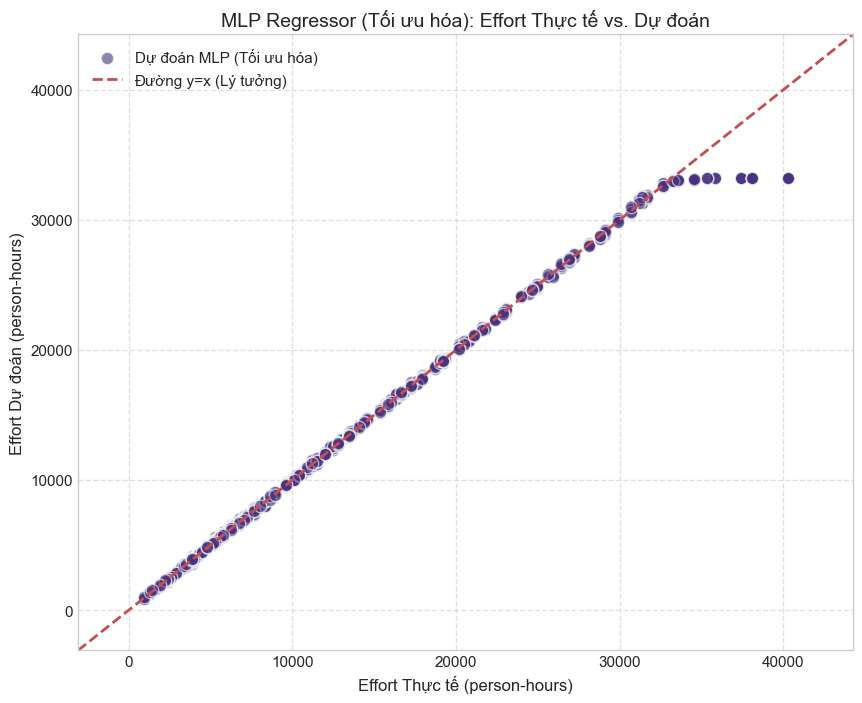

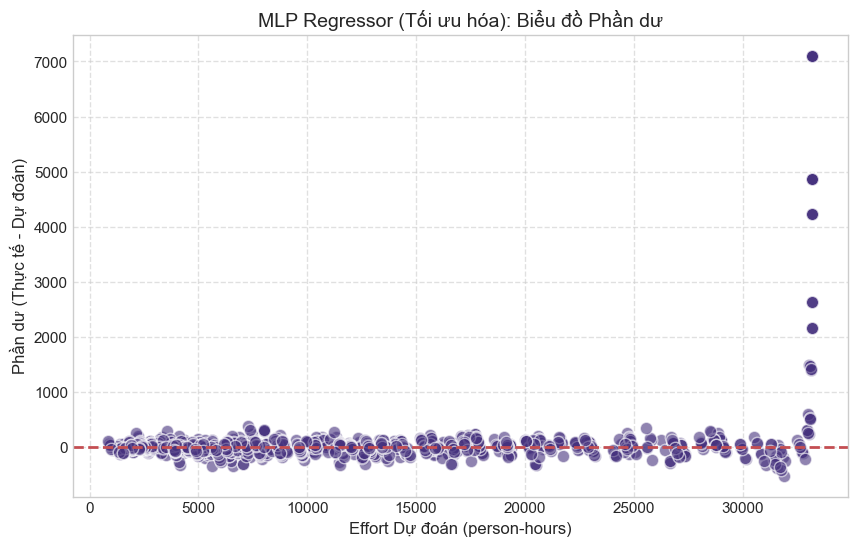


--- Hoàn thành (MLP Regressor - Tối ưu hóa Siêu tham số) ---


In [47]:
# -*- coding: utf-8 -*-
"""
Mục tiêu:
1. Sử dụng RandomizedSearchCV để tìm kiếm siêu tham số tốt cho MLPRegressor.
2. Huấn luyện mô hình MLP tốt nhất tìm được.
3. Dự đoán effort trên tập kiểm thử đã xử lý.
4. Tính toán các chỉ số đánh giá (MAE, RMSE, R²).
5. Trực quan hóa kết quả (Scatter plot, Residual plot).

Thư viện sử dụng: scikit-learn, matplotlib, seaborn, numpy, pandas, scipy
"""

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV # *** THÊM IMPORT ***
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Import các hàm phân phối cho RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings # Thêm để xử lý warning (tùy chọn)

# Tạm thời bỏ qua ConvergenceWarning nếu muốn
# from sklearn.exceptions import ConvergenceWarning
# warnings.filterwarnings("ignore", category=ConvergenceWarning)


# --- Quan trọng: Giả định các biến sau đã tồn tại từ các cell trước ---
# X_train_processed: Dữ liệu huấn luyện đặc trưng (từ Prompt 1 chống rò rỉ)
# X_test_processed: Dữ liệu kiểm thử đặc trưng (từ Prompt 1 chống rò rỉ)
# y_train: Dữ liệu huấn luyện mục tiêu (từ Prompt 1 chống rò rỉ)
# y_test: Dữ liệu kiểm thử mục tiêu (từ Prompt 1 chống rò rỉ)
# mae_linear, rmse_linear, r2_linear: Kết quả từ Linear Regression (Prompt 2)
# mae_dt, rmse_dt, r2_dt: Kết quả từ Decision Tree (Prompt 3)
# mae_rf, rmse_rf, r2_rf: Kết quả từ Random Forest (Prompt 4)
# mae_xgb, rmse_xgb, r2_xgb: Kết quả từ XGBoost (Prompt 5, nếu đã chạy)
# ---------------------------------------------------------------------------

# Kiểm tra sự tồn tại của biến (đề phòng)
required_vars_p6_tuned_adv = ['X_train_processed', 'X_test_processed', 'y_train', 'y_test',
                              'mae_linear', 'rmse_linear', 'r2_linear',
                              'mae_dt', 'rmse_dt', 'r2_dt',
                              'mae_rf', 'rmse_rf', 'r2_rf']
# Thêm kiểm tra cho biến XGBoost nếu có
if 'mae_xgb' in globals():
     required_vars_p6_tuned_adv.extend(['mae_xgb', 'rmse_xgb', 'r2_xgb'])

if not all(var in globals() for var in required_vars_p6_tuned_adv):
    raise NameError("LỖI: Một hoặc nhiều biến cần thiết không tồn tại. Hãy chạy lại các cell Prompt 1-4 (và 5 nếu có) trước.")

print("--- Bước 1: Tối ưu hóa Siêu tham số MLPRegressor bằng RandomizedSearchCV ---")

# 1.1. Định nghĩa không gian phân phối tham số để tìm kiếm
# Đây là nơi bạn định nghĩa các khoảng giá trị hoặc danh sách các giá trị muốn thử
param_dist_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 30), (100, 50), (128, 64), (64, 32)], # List các kiến trúc thử nghiệm
    'activation': ['relu', 'tanh'],
    'solver': ['adam'], # Giữ adam cho đơn giản
    'alpha': loguniform(1e-5, 1e-1), # Phân phối log-uniform cho alpha (0.00001 đến 0.1)
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': loguniform(1e-4, 1e-2), # Phân phối log-uniform cho tốc độ học (0.0001 đến 0.01)
    'batch_size': [32, 64, 128], # Thử các batch size khác nhau
}
print("Không gian phân phối tham số tìm kiếm:")
for key, value in param_dist_mlp.items():
    print(f"  {key}: {value}")


# 1.2. Khởi tạo MLPRegressor cơ sở (với các tham số cố định)
mlp_base = MLPRegressor(random_state=42,
                        max_iter=1000, # Đặt max_iter cao để không giới hạn RandomizedSearch
                        early_stopping=True, # Vẫn dùng early stopping trong mỗi lần thử
                        validation_fraction=0.1,
                        n_iter_no_change=15,
                        verbose=False)

# 1.3. Khởi tạo RandomizedSearchCV
# n_iter: Số lượng kết hợp tham số ngẫu nhiên để thử (tăng lên nếu có thời gian)
# cv: Số fold cross-validation
n_iterations_search = 15 # Số lần thử nghiệm tham số (tăng nếu muốn kỹ hơn)
cv_folds = 3           # Số fold CV (giảm nếu chạy quá lâu)

random_search_mlp = RandomizedSearchCV(
    estimator=mlp_base,
    param_distributions=param_dist_mlp,
    n_iter=n_iterations_search,
    cv=cv_folds,
    scoring='r2', # Hoặc 'neg_root_mean_squared_error'
    n_jobs=-1,    # Sử dụng tất cả CPU cores
    random_state=42,
    verbose=2     # Hiển thị chi tiết quá trình tìm kiếm
)

print(f"\nBắt đầu RandomizedSearchCV với {n_iterations_search} lần thử và {cv_folds}-fold CV...")
# Tìm kiếm trên dữ liệu huấn luyện ĐÃ XỬ LÝ CHUẨN
random_search_mlp.fit(X_train_processed, y_train)

# 1.4. Lấy ra mô hình và tham số tốt nhất
best_mlp_model = random_search_mlp.best_estimator_
print(f"\nĐiểm R2 tốt nhất từ Cross-Validation: {random_search_mlp.best_score_:.4f}")
print("Đã tìm thấy bộ tham số tốt nhất:")
print(random_search_mlp.best_params_)
print("Mô hình MLP tốt nhất đã được huấn luyện lại trên toàn bộ tập train.")

# --- Bước 2: Dự đoán Effort trên Tập Kiểm thử ---
print("\n--- Bước 2: Dự đoán trên Tập Kiểm thử bằng mô hình MLP tốt nhất ---")
y_pred_mlp = best_mlp_model.predict(X_test_processed) # Sử dụng mô hình tốt nhất
print("Đã thực hiện dự đoán trên X_test_processed.")

# --- Bước 3: Đánh giá Mô hình ---
print("\n--- Bước 3: Đánh giá Hiệu suất Mô hình MLP (Tối ưu hóa) trên tập Test ---") # Cập nhật tiêu đề

# Tính toán các chỉ số
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
r2_mlp = r2_score(y_test, y_pred_mlp) # R2 trên tập test

# Lưu kết quả vào biến để dùng ở prompt sau (nếu cần)
globals().update({'mae_mlp': mae_mlp, 'rmse_mlp': rmse_mlp, 'r2_mlp': r2_mlp})

print(f"Mean Absolute Error (MAE): {mae_mlp:.2f} person-hours")
print(f"Root Mean Squared Error (RMSE): {rmse_mlp:.2f} person-hours")
print(f"R² Score (trên tập test): {r2_mlp:.4f}")

# So sánh với các mô hình trước
print(f"\nSo sánh với các mô hình trước:")
print(f"  Model             | MAE      | RMSE     | R² Score")
print(f"------------------|----------|----------|----------")
print(f"  Linear Regression | {mae_linear:8.2f} | {rmse_linear:8.2f} | {r2_linear:8.4f}")
print(f"  Decision Tree     | {mae_dt:8.2f} | {rmse_dt:8.2f} | {r2_dt:8.4f}")
print(f"  Random Forest     | {mae_rf:8.2f} | {rmse_rf:8.2f} | {r2_rf:8.4f}")
# In kết quả XGBoost nếu có
if 'mae_xgb' in globals():
    print(f"  XGBoost           | {mae_xgb:8.2f} | {rmse_xgb:8.2f} | {r2_xgb:8.4f}")
print(f"  MLP Regressor Opt | {mae_mlp:8.2f} | {rmse_mlp:8.2f} | {r2_mlp:8.4f}") # Cập nhật tên model


# --- Bước 4: Trực quan hóa Kết quả ---
print("\n--- Bước 4: Trực quan hóa Kết quả ---")

# 4.1. Biểu đồ Scatter Plot: Giá trị Thực tế vs. Giá trị Dự đoán
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_mlp, alpha=0.6, edgecolors='w', s=80, label='Dự đoán MLP (Tối ưu hóa)') # Cập nhật label
max_val = max(y_test.max(), y_pred_mlp.max())
min_val = min(y_test.min(), y_pred_mlp.min())
plot_min = min_val - (max_val - min_val) * 0.1
plot_max = max_val + (max_val - min_val) * 0.1
plt.plot([plot_min, plot_max], [plot_min, plot_max], 'r--', lw=2, label='Đường y=x (Lý tưởng)')
plt.xlabel('Effort Thực tế (person-hours)', fontsize=12)
plt.ylabel('Effort Dự đoán (person-hours)', fontsize=12)
plt.title('MLP Regressor (Tối ưu hóa): Effort Thực tế vs. Dự đoán', fontsize=14) # Cập nhật title
plt.xlim(plot_min, plot_max)
plt.ylim(plot_min, plot_max)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 4.2. Biểu đồ Residual Plot: Giá trị Dự đoán vs. Phần dư
residuals_mlp = y_test - y_pred_mlp

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_mlp, residuals_mlp, alpha=0.6, edgecolors='w', s=80)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Effort Dự đoán (person-hours)', fontsize=12)
plt.ylabel('Phần dư (Thực tế - Dự đoán)', fontsize=12)
plt.title('MLP Regressor (Tối ưu hóa): Biểu đồ Phần dư', fontsize=14) # Cập nhật title
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
print("\n--- Hoàn thành (MLP Regressor - Tối ưu hóa Siêu tham số) ---") # Cập nhật tên prompt


--- Bước 1: Định nghĩa Hàm Tính COCOMO II Cơ bản ---
Đã định nghĩa hàm calculate_cocomo_basic.
Sử dụng các hằng số A, B: {'organic': {'A': 2.4, 'B': 1.05}, 'semi-detached': {'A': 3.0, 'B': 1.12}, 'embedded': {'A': 3.6, 'B': 1.2}}
Giả định quy đổi: 1 PM = 152.0 person-hours

--- Bước 2: Chọn Mẫu, Giả định và Tính toán Effort COCOMO II ---
Giả định Product(EM_i) = 1.0 (Bạn có thể thay đổi giá trị này trong code)
Tính toán cho 2000 mẫu đầu tiên của tập test, giả định mode = 'semi-detached'.

--- Bước 3: Kết quả So sánh (Bảng - 20 dòng đầu) ---
>>> Hãy xem bảng này để thấy giá trị Effort COCOMO dự đoán cụ thể:
Index         LOC   Actual Effort Assumed Mode         COCOMO Effort
----------------------------------------------------------------------
6252        11.44       11,520.00 semi-detached                 3.05
4684        17.40        7,680.00 semi-detached                 4.88
1731        12.51       13,440.00 semi-detached                 3.37
4742        56.16        6,720.00 semi-

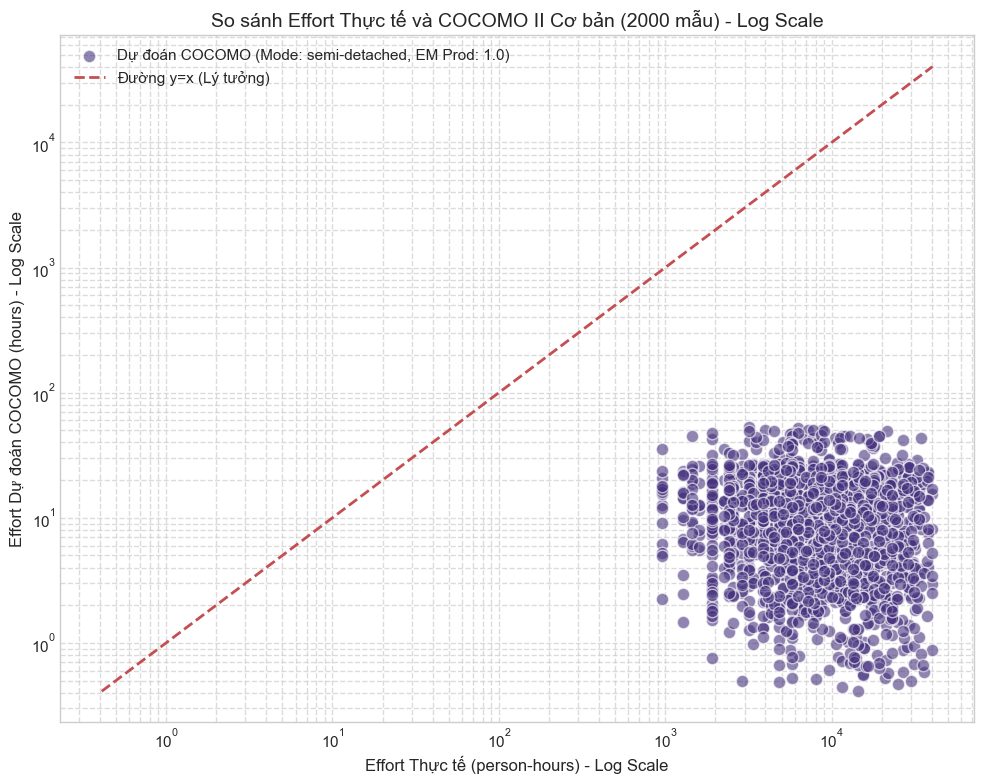


Lưu ý: Kết quả COCOMO II cơ bản này chỉ mang tính minh họa và phụ thuộc nhiều vào các giả định.

--- Hoàn thành (Code Tính toán COCOMO II - Log Plot) ---


In [48]:
# -*- coding: utf-8 -*-
"""
Mục tiêu:
1. Định nghĩa hàm tính COCOMO II cơ bản với các giả định.
2. Lấy dữ liệu LOC và Effort thực tế từ tập kiểm thử gốc (X_test, y_test).
3. Áp dụng công thức COCOMO II cơ bản cho một vài mẫu (n_samples), cho phép thay đổi EM giả định.
4. Hiển thị kết quả so sánh dạng bảng (nhiều dòng hơn).
5. Vẽ biểu đồ scatter plot (thang đo log) so sánh effort thực tế và COCOMO.

Thư viện sử dụng: pandas, numpy, matplotlib, math
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math # Dùng cho hàm pow

# --- Quan trọng: Giả định các biến sau đã tồn tại từ các cell trước ---
# X_test: DataFrame chứa các đặc trưng GỐC của tập kiểm thử (phải chứa cột 'LOC')
# y_test: Series chứa giá trị Effort thực tế (person-hours) của tập kiểm thử
# ---------------------------------------------------------------------------

# Kiểm tra sự tồn tại của biến (đề phòng)
required_vars_p7_code = ['X_test', 'y_test']
if not all(var in globals() for var in required_vars_p7_code):
    raise NameError("LỖI: Biến X_test hoặc y_test không tồn tại. Hãy chạy lại cell Prompt 1 (chống rò rỉ) để tạo chúng.")
if not isinstance(X_test, pd.DataFrame):
     raise TypeError("LỖI: X_test phải là một pandas DataFrame (dữ liệu gốc trước xử lý).")
if 'LOC' not in X_test.columns:
     raise ValueError("LỖI: Cột 'LOC' không tồn tại trong X_test. Hãy đảm bảo X_test là dữ liệu gốc.")

print("--- Bước 1: Định nghĩa Hàm Tính COCOMO II Cơ bản ---")

# Các hằng số A, B theo mô hình dự án (Size tính bằng KLOC)
COCOMO_PARAMS = {
    'organic': {'A': 2.4, 'B': 1.05},
    'semi-detached': {'A': 3.0, 'B': 1.12},
    'embedded': {'A': 3.6, 'B': 1.20}
}

# Hệ số quy đổi giả định từ Person-Months sang Person-Hours
HOURS_PER_PM = 152.0 # Sử dụng float để tính toán chính xác hơn

def calculate_cocomo_basic(loc, mode='semi-detached', product_em=1.0, hours_per_pm=HOURS_PER_PM):
    """Tính toán Effort COCOMO II cơ bản."""
    if mode not in COCOMO_PARAMS:
        print(f"Lỗi: Mô hình dự án '{mode}' không hợp lệ.")
        return None
    if loc < 0:
        print("Lỗi: LOC không thể là số âm.")
        return None
    if loc == 0:
        return 0.0
    params = COCOMO_PARAMS[mode]
    A = params['A']; B = params['B']
    size_kloc = loc / 1000.0
    # Tránh lỗi log(0) hoặc pow(0, negative) nếu size_kloc quá nhỏ hoặc B < 0 (ít xảy ra)
    if size_kloc <= 0: return 0.0
    try:
        effort_pm = A * math.pow(size_kloc, B) * product_em
    except ValueError: # Xử lý trường hợp math.pow lỗi (ví dụ 0 mũ âm)
        return 0.0
    effort_hours = effort_pm * hours_per_pm
    return effort_hours

print("Đã định nghĩa hàm calculate_cocomo_basic.")
print(f"Sử dụng các hằng số A, B: {COCOMO_PARAMS}")
print(f"Giả định quy đổi: 1 PM = {HOURS_PER_PM} person-hours")

# --- Bước 2: Chọn Mẫu, Giả định và Tính toán ---
print("\n--- Bước 2: Chọn Mẫu, Giả định và Tính toán Effort COCOMO II ---")

# *** THAY ĐỔI: Cho phép điều chỉnh EM giả định ***
# Giá trị 1.0 tương ứng với việc bỏ qua các hệ số EM.
# Bạn có thể thử tăng giá trị này (ví dụ: 1.5, 2.0) để xem effort COCOMO thay đổi thế nào.
assumed_product_em = 1.0
print(f"Giả định Product(EM_i) = {assumed_product_em} (Bạn có thể thay đổi giá trị này trong code)")

# Chọn số lượng mẫu để tính toán và hiển thị (ví dụ: 300)
n_samples = 5000
sample_indices = X_test.head(n_samples).index
if not y_test.index.isin(sample_indices).all():
     common_indices = X_test.index.intersection(y_test.index)
     sample_indices = common_indices[:n_samples]
     if len(sample_indices) < n_samples:
          print(f"Cảnh báo: Chỉ tìm thấy {len(sample_indices)} index chung giữa X_test và y_test.")

# Lấy dữ liệu LOC và Effort thực tế cho các mẫu này
sample_loc = X_test.loc[sample_indices, 'LOC']
sample_actual_effort = y_test.loc[sample_indices]

# Giả định mô hình dự án cho tất cả các mẫu (ví dụ: 'semi-detached')
assumed_mode = 'semi-detached'
print(f"Tính toán cho {len(sample_indices)} mẫu đầu tiên của tập test, giả định mode = '{assumed_mode}'.")

results = []
for idx in sample_indices:
    loc_value = X_test.loc[idx, 'LOC']
    actual_effort = y_test.loc[idx]
    # *** THAY ĐỔI: Truyền assumed_product_em vào hàm ***
    cocomo_effort = calculate_cocomo_basic(loc_value, mode=assumed_mode, product_em=assumed_product_em)
    results.append({
        'Index': idx,
        'LOC': loc_value,
        'Actual Effort (hours)': actual_effort,
        'Assumed Mode': assumed_mode,
        'COCOMO Effort (hours)': cocomo_effort if cocomo_effort is not None else np.nan
    })

# Tạo DataFrame từ kết quả
results_df = pd.DataFrame(results)
results_df.dropna(subset=['COCOMO Effort (hours)'], inplace=True) # Loại bỏ các dòng tính toán lỗi (nếu có)

# --- Bước 3: Hiển thị Kết quả So sánh (Bảng) ---
print("\n--- Bước 3: Kết quả So sánh (Bảng - 20 dòng đầu) ---")
print(">>> Hãy xem bảng này để thấy giá trị Effort COCOMO dự đoán cụ thể:")
# Sử dụng f-string để định dạng số tốt hơn trong print
print(f"{'Index':<6} {'LOC':>10} {'Actual Effort':>15} {'Assumed Mode':<15} {'COCOMO Effort':>18}")
print("-" * 70)
# *** THAY ĐỔI: In 20 dòng đầu ***
for _, row in results_df.head(20).iterrows():
    print(f"{int(row['Index']):<6d} {row['LOC']:>10,.2f} {row['Actual Effort (hours)']:>15,.2f} {row['Assumed Mode']:<15} {row['COCOMO Effort (hours)']:>18,.2f}")

# --- Bước 4: Vẽ Biểu đồ So sánh (Log-Log Scatter Plot) ---
# *** Thay đổi: Sử dụng Thang đo Logarit ***
print("\n--- Bước 4: Vẽ Biểu đồ So sánh (Log-Log Scatter Plot) ---")
print(">>> Sử dụng thang đo logarit để nhìn rõ hơn sự phân bố khi giá trị chênh lệch lớn.")

if not results_df.empty:
    # Lọc bỏ các giá trị không dương trước khi vẽ log scale
    plot_df = results_df[(results_df['Actual Effort (hours)'] > 0) & (results_df['COCOMO Effort (hours)'] > 0)].copy()

    if not plot_df.empty:
        plt.figure(figsize=(10, 8))

        # Vẽ scatter plot
        plt.scatter(plot_df['Actual Effort (hours)'], plot_df['COCOMO Effort (hours)'],
                    alpha=0.6, edgecolors='w', s=80, label=f'Dự đoán COCOMO (Mode: {assumed_mode}, EM Prod: {assumed_product_em})')

        # Vẽ đường y=x (lý tưởng)
        # Xác định giới hạn trục dựa trên giá trị min/max SAU KHI LỌC
        min_val = plot_df[['Actual Effort (hours)', 'COCOMO Effort (hours)']].min().min()
        max_val = plot_df[['Actual Effort (hours)', 'COCOMO Effort (hours)']].max().max()
        # Tạo đường chéo trong không gian log hoặc không gian thường tùy thẩm mỹ
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Đường y=x (Lý tưởng)')

        # *** THAY ĐỔI: Đặt thang đo logarit ***
        plt.xscale('log')
        plt.yscale('log')

        plt.xlabel('Effort Thực tế (person-hours) - Log Scale', fontsize=12)
        plt.ylabel('Effort Dự đoán COCOMO (hours) - Log Scale', fontsize=12)
        plt.title(f'So sánh Effort Thực tế và COCOMO II Cơ bản ({len(plot_df)} mẫu) - Log Scale', fontsize=14)
        # Giới hạn trục có thể không cần thiết với log scale, hoặc cần đặt cẩn thận
        # plt.xlim(min_val * 0.8, max_val * 1.2) # Ví dụ giới hạn cho log scale
        # plt.ylim(min_val * 0.8, max_val * 1.2)
        plt.legend()
        plt.grid(True, which='both', linestyle='--', alpha=0.7) # Grid cho cả major và minor ticks trên log scale
        plt.tight_layout()
        plt.show()
    else:
        print("Không có đủ dữ liệu dương để vẽ biểu đồ log-log scatter plot.")
else:
    print("Không có dữ liệu mẫu để vẽ biểu đồ.")

print("\nLưu ý: Kết quả COCOMO II cơ bản này chỉ mang tính minh họa và phụ thuộc nhiều vào các giả định.")
print("\n--- Hoàn thành (Code Tính toán COCOMO II - Log Plot) ---")


Sẵn sàng định nghĩa hàm COCOMO II, trực quan hóa và áp dụng lên dataset.

--- Thử nghiệm hàm estimate_cocomo_effort ---
Ví dụ 1: Size=50 KLOC, Type='organic' -> Estimated Effort = 145.93 person-hours
Ví dụ 2: Size=500 (đơn vị giả định), Type='semi-detached' -> Estimated Effort = 3162.04 person-hours
Ví dụ 3: Size=100 KLOC, Type='Embedded' -> Estimated Effort = 904.28 person-hours
Ví dụ 4: Size=-10 (không hợp lệ) -> Hàm trả về None đúng như mong đợi.
Ví dụ 5: Size=50 KLOC, Type='experimental' (không xác định) -> Estimated Effort = 145.93 person-hours (dùng mặc định organic)

--- Bước 6: Trực quan hóa Effort COCOMO II theo Size và Loại Dự án (trên dãy size tự tạo) ---


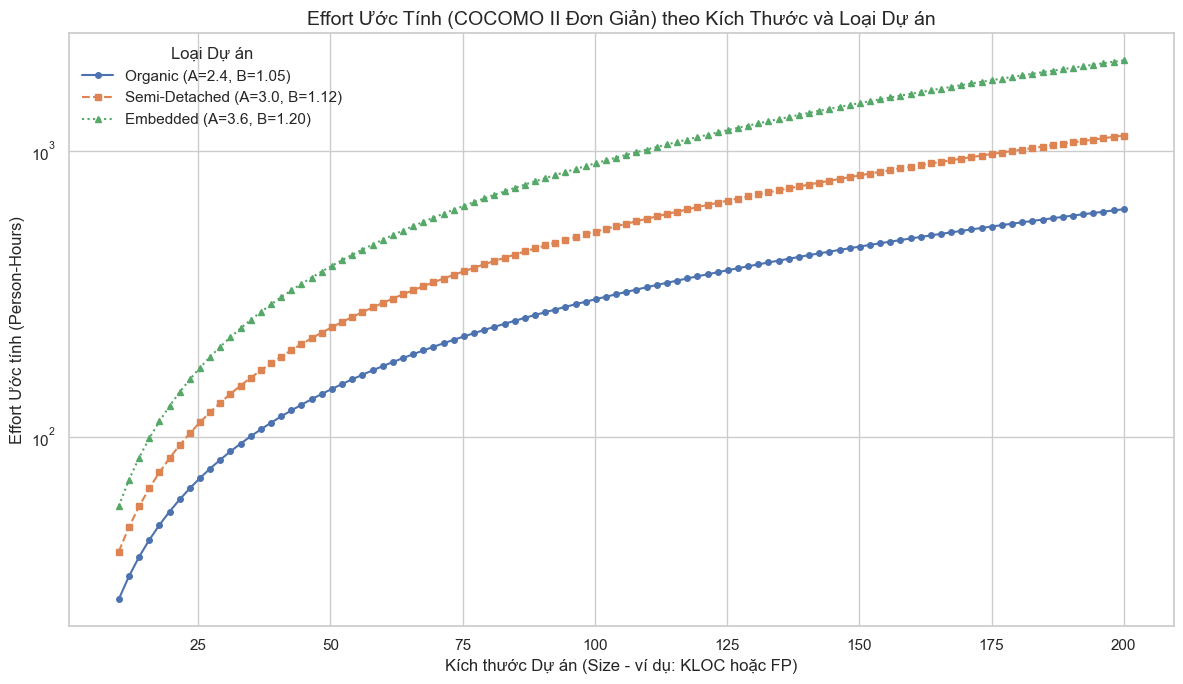


--- Bước 7: Áp dụng COCOMO II lên dữ liệu thực tế từ dataset.csv ---
DataFrame 'df' hợp lệ. Áp dụng hàm estimate_cocomo_effort...
Lưu ý: Giả định cột 'LOC' trong dataset là KLOC (nghìn dòng code). Nếu không, cần điều chỉnh.
Đã tính toán xong ước tính COCOMO II cho toàn bộ dataset.

5 dòng đầu với Effort thực tế và Effort ước tính COCOMO II:


,LOC,Project Type,Effort (person-hours),COCOMO_Estimate
0,29.90,Web,20800,85.048369
1,57.12,Web,18720,167.818120
2,28.32,Web,8000,80.335806
3,52.14,Embedded,3840,413.911729
4,30.08,Mobile,3840,85.586046



Đánh giá hiệu năng của COCOMO II (đơn giản) trên toàn bộ dataset:
  Mean Absolute Error (MAE): 9830.6111
  Mean Squared Error (MSE):  158809320.5943
  Root Mean Squared Error (RMSE): 12601.9570
  R-squared (R²) Score:       -1.5791 (Giá trị gần 1 là tốt nhất)


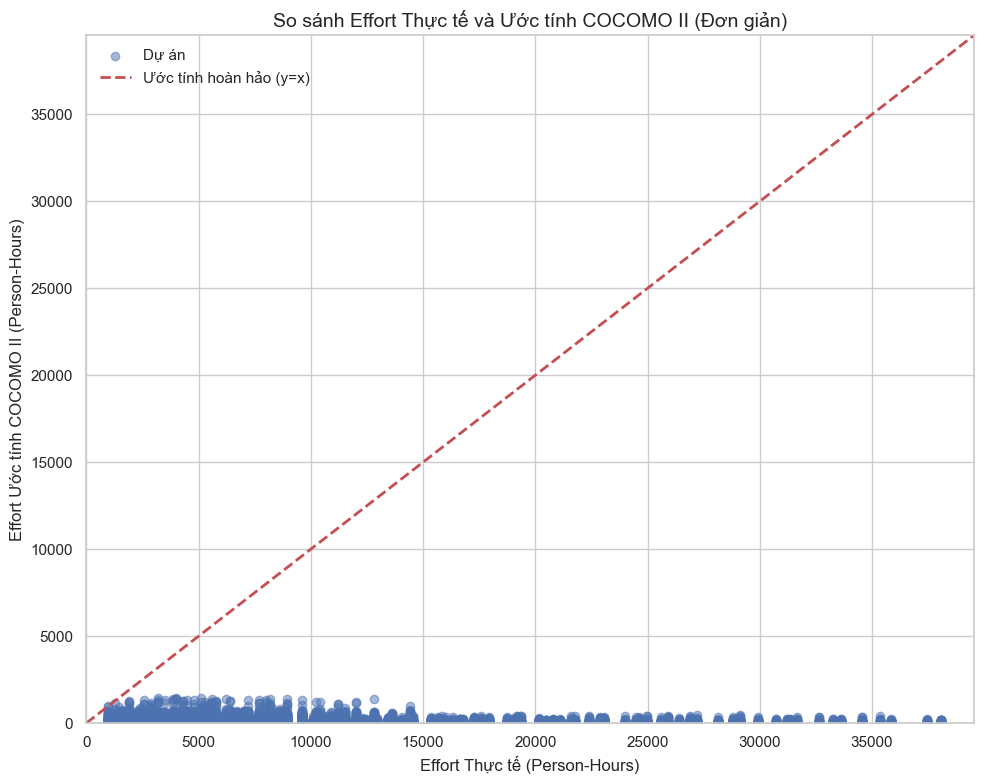


--- Lưu ý ---
1. Đây là phiên bản COCOMO II rất đơn giản hóa (Basic COCOMO).
2. Mô hình COCOMO II đầy đủ phức tạp hơn nhiều, bao gồm các Cost Drivers (nhân tố chi phí) và Scale Factors (nhân tố quy mô).
3. Giả định quan trọng: Cột 'LOC' trong dataset được cung cấp dưới dạng KLOC (nghìn dòng code). Nếu đơn vị khác, kết quả sẽ sai.
4. Độ chính xác của mô hình này phụ thuộc rất nhiều vào việc lựa chọn đúng loại dự án và chất lượng dữ liệu đầu vào.
5. Kết quả đánh giá (MAE, RMSE, R²) cho thấy mức độ phù hợp của mô hình COCOMO II đơn giản này với dữ liệu thực tế của bạn.

Hoàn tất định nghĩa, thử nghiệm, trực quan hóa và áp dụng hàm COCOMO II.


In [50]:
# -*- coding: utf-8 -*-

# =============================================================================
# Bước 0: Import thư viện
# =============================================================================
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Thêm thư viện metrics để đánh giá COCOMO trên dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from IPython.display import display # Import display explicitely

print("Sẵn sàng định nghĩa hàm COCOMO II, trực quan hóa và áp dụng lên dataset.")

# Thiết lập style cho biểu đồ (tùy chọn)
sns.set_theme(style="whitegrid")

# =============================================================================
# Bước 1-4: Định nghĩa hàm estimate_cocomo_effort
# =============================================================================

def estimate_cocomo_effort(size, project_type='organic'):
    """
    Ước tính effort phát triển phần mềm (person-hours) dựa trên mô hình COCOMO II đơn giản.
    (Docstring và code hàm giữ nguyên như trước)
    """
    # Kiểm tra đầu vào size
    if not isinstance(size, (int, float)) or size <= 0:
        # print(f"LỖI: Kích thước (size) phải là một số dương. Nhận được: {size}")
        # Tạm ẩn lỗi khi áp dụng hàng loạt để tránh quá nhiều output
        return None

    # Chuẩn hóa project_type về chữ thường
    project_type = str(project_type).lower() # Đảm bảo project_type là string

    # Chọn hằng số A và B
    if project_type == 'organic':
        A = 2.4
        B = 1.05
    elif project_type == 'semi-detached':
        A = 3.0
        B = 1.12
    elif project_type == 'embedded':
        A = 3.6
        B = 1.20
    else:
        A = 2.4 # Mặc định organic
        B = 1.05

    # Tính toán Effort
    try:
        # QUAN TRỌNG: Giả định 'size' đầu vào (từ cột LOC) là KLOC (nghìn dòng code)
        # Nếu cột LOC trong file csv là số dòng code thực tế, bạn cần chia cho 1000 trước khi đưa vào đây.
        # Ví dụ: effort = A * ((size / 1000) ** B)
        # Ở đây, tạm giả định size đã là KLOC hoặc đơn vị phù hợp.
        effort = A * (size ** B)
    except OverflowError:
        # print(f"LỖI: OverflowError khi tính toán effort cho size={size}")
        return None
    except Exception as e:
        # print(f"LỖI: Lỗi không xác định khi tính toán effort: {e}")
        return None

    return effort

# =============================================================================
# Bước 5: Thử nghiệm hàm với các giá trị ví dụ
# =============================================================================
print("\n--- Thử nghiệm hàm estimate_cocomo_effort ---")
# (Các ví dụ gọi hàm vẫn giữ nguyên như trước)
size_kloc_1 = 50
effort_1 = estimate_cocomo_effort(size_kloc_1, 'organic')
if effort_1 is not None:
    print(f"Ví dụ 1: Size={size_kloc_1} KLOC, Type='organic' -> Estimated Effort = {effort_1:.2f} person-hours")

size_fp_2 = 500 # Giả sử size này là Function Points hoặc đơn vị khác phù hợp với semi-detached
effort_2 = estimate_cocomo_effort(size_fp_2, 'semi-detached')
if effort_2 is not None:
    print(f"Ví dụ 2: Size={size_fp_2} (đơn vị giả định), Type='semi-detached' -> Estimated Effort = {effort_2:.2f} person-hours")

size_kloc_3 = 100
effort_3 = estimate_cocomo_effort(size_kloc_3, 'Embedded') # Chấp nhận chữ hoa/thường
if effort_3 is not None:
    print(f"Ví dụ 3: Size={size_kloc_3} KLOC, Type='Embedded' -> Estimated Effort = {effort_3:.2f} person-hours")

# Thử nghiệm với giá trị size không hợp lệ
invalid_size = -10
effort_invalid = estimate_cocomo_effort(invalid_size, 'organic')
if effort_invalid is None:
    print(f"Ví dụ 4: Size={invalid_size} (không hợp lệ) -> Hàm trả về None đúng như mong đợi.")

# Thử nghiệm với project_type không xác định (sẽ dùng mặc định 'organic')
unknown_type = 'experimental'
effort_unknown = estimate_cocomo_effort(size_kloc_1, unknown_type)
if effort_unknown is not None:
     print(f"Ví dụ 5: Size={size_kloc_1} KLOC, Type='{unknown_type}' (không xác định) -> Estimated Effort = {effort_unknown:.2f} person-hours (dùng mặc định organic)")


# =============================================================================
# Bước 6: Trực quan hóa ảnh hưởng của Size và Project Type (trên dữ liệu giả định)
# =============================================================================
print("\n--- Bước 6: Trực quan hóa Effort COCOMO II theo Size và Loại Dự án (trên dãy size tự tạo) ---")
# Tạo một dãy các giá trị kích thước (ví dụ: từ 10 KLOC đến 200 KLOC)
sizes = np.linspace(10, 200, 100) # 100 điểm dữ liệu từ 10 đến 200

# Tính toán effort ước tính cho từng loại dự án với các kích thước khác nhau
efforts = {
    'Size': sizes,
    'Organic': [estimate_cocomo_effort(s, 'organic') for s in sizes],
    'Semi-Detached': [estimate_cocomo_effort(s, 'semi-detached') for s in sizes],
    'Embedded': [estimate_cocomo_effort(s, 'embedded') for s in sizes]
}

# Tạo DataFrame từ dictionary efforts
df_efforts = pd.DataFrame(efforts)

# Vẽ biểu đồ đường
plt.figure(figsize=(12, 7)) # Kích thước biểu đồ

# Vẽ đường cho từng loại dự án
plt.plot(df_efforts['Size'], df_efforts['Organic'], label='Organic (A=2.4, B=1.05)', marker='o', markersize=4, linestyle='-')
plt.plot(df_efforts['Size'], df_efforts['Semi-Detached'], label='Semi-Detached (A=3.0, B=1.12)', marker='s', markersize=4, linestyle='--')
plt.plot(df_efforts['Size'], df_efforts['Embedded'], label='Embedded (A=3.6, B=1.20)', marker='^', markersize=4, linestyle=':')

# Đặt tên cho các trục và tiêu đề
plt.xlabel("Kích thước Dự án (Size - ví dụ: KLOC hoặc FP)", fontsize=12)
plt.ylabel("Effort Ước tính (Person-Hours)", fontsize=12)
plt.title("Effort Ước Tính (COCOMO II Đơn Giản) theo Kích Thước và Loại Dự án", fontsize=14)

# Hiển thị chú giải (legend)
plt.legend(title="Loại Dự án")

# Hiển thị lưới
plt.grid(True)

# Sử dụng thang đo log cho trục y để dễ quan sát sự khác biệt ở các giá trị nhỏ và lớn
plt.yscale('log')

# Tối ưu layout
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()


# =============================================================================
# Bước 7: Áp dụng hàm COCOMO II lên dữ liệu thực tế (dataset.csv)
# =============================================================================
print("\n--- Bước 7: Áp dụng COCOMO II lên dữ liệu thực tế từ dataset.csv ---")

# Giả sử 'df' là DataFrame đã được tải từ file CSV ở một bước trước đó
# Ví dụ: df = pd.read_csv('dataset.csv')
# Cần đảm bảo DataFrame 'df' tồn tại và có các cột cần thiết.

# Kiểm tra xem DataFrame 'df' gốc có tồn tại không (ví dụ từ prompt trước)
# Trong môi trường thực tế, bạn sẽ tải dữ liệu ở đây nếu chưa có.
# Ví dụ:
# try:
#     df = pd.read_csv('dataset.csv') # Thay 'dataset.csv' bằng tên file của bạn
#     print("Đã tải thành công dataset.csv")
# except FileNotFoundError:
#     print("LỖI: Không tìm thấy file dataset.csv. Vui lòng đảm bảo file tồn tại.")
#     df = None # Đặt df là None nếu không tải được

# Giả định df đã được tải ở prompt trước, ta kiểm tra sự tồn tại của nó
if 'df' not in globals() or not isinstance(df, pd.DataFrame):
    print("LỖI: DataFrame 'df' chứa dữ liệu gốc không tồn tại hoặc không hợp lệ.")
    print("Vui lòng đảm bảo bạn đã chạy code ở Prompt 1 để tải dữ liệu vào 'df'.")
    # Hoặc bạn có thể thêm code tải lại dữ liệu ở đây nếu muốn.
else:
    # Đảm bảo các cột cần thiết tồn tại trong DataFrame
    required_cols = ['LOC', 'Project Type', 'Effort (person-hours)'] # Các cột cần thiết
    if not all(col in df.columns for col in required_cols):
        print(f"LỖI: DataFrame 'df' thiếu một hoặc nhiều cột cần thiết: {required_cols}")
        print(f"Các cột hiện có: {list(df.columns)}")
    else:
        print("DataFrame 'df' hợp lệ. Áp dụng hàm estimate_cocomo_effort...")

        # Tạo cột mới chứa kết quả ước tính COCOMO II
        # Sử dụng df.apply với lambda function để áp dụng hàm cho từng hàng
        # Lưu ý quan trọng về đơn vị của cột 'LOC':
        # Hàm estimate_cocomo_effort giả định 'size' là KLOC.
        # Nếu cột 'LOC' trong file csv của bạn là số dòng code thực tế,
        # bạn cần chia nó cho 1000 trước khi truyền vào hàm.
        print("Lưu ý: Giả định cột 'LOC' trong dataset là KLOC (nghìn dòng code). Nếu không, cần điều chỉnh.")
        # Ví dụ điều chỉnh nếu LOC là số dòng code thực:
        # df['COCOMO_Estimate'] = df.apply(
        #     lambda row: estimate_cocomo_effort(row['LOC'] / 1000, row['Project Type'])
        #     if pd.notna(row['LOC']) and row['LOC'] > 0 else None, # Chia cho 1000 và kiểm tra NaN/zero
        #     axis=1
        # )
        # Ở đây, ta giữ nguyên giả định LOC là KLOC:
        df['COCOMO_Estimate'] = df.apply(
            lambda row: estimate_cocomo_effort(row['LOC'], row['Project Type'])
            if pd.notna(row['LOC']) else None, # Chỉ áp dụng nếu LOC không phải NaN
            axis=1 # Áp dụng hàm cho từng hàng (axis=1)
        )

        print("Đã tính toán xong ước tính COCOMO II cho toàn bộ dataset.")

        # Hiển thị 5 dòng đầu với kết quả ước tính
        print("\n5 dòng đầu với Effort thực tế và Effort ước tính COCOMO II:")
        # Sử dụng display() để hiển thị DataFrame đẹp hơn trong môi trường như Jupyter
        display(df[['LOC', 'Project Type', 'Effort (person-hours)', 'COCOMO_Estimate']].head())

        # --- Đánh giá hiệu năng của ước tính COCOMO II so với thực tế ---
        print("\nĐánh giá hiệu năng của COCOMO II (đơn giản) trên toàn bộ dataset:")

        # Chỉ đánh giá trên các hàng có cả giá trị thực tế và giá trị ước tính hợp lệ
        df_valid_cocomo = df.dropna(subset=['Effort (person-hours)', 'COCOMO_Estimate'])

        if not df_valid_cocomo.empty:
            y_true_cocomo = df_valid_cocomo['Effort (person-hours)']
            y_pred_cocomo = df_valid_cocomo['COCOMO_Estimate']

            # Tính toán các metrics
            mae_cocomo = mean_absolute_error(y_true_cocomo, y_pred_cocomo)
            mse_cocomo = mean_squared_error(y_true_cocomo, y_pred_cocomo)
            rmse_cocomo = np.sqrt(mse_cocomo) # Hoặc mean_squared_error(..., squared=False)
            r2_cocomo = r2_score(y_true_cocomo, y_pred_cocomo)

            print(f"  Mean Absolute Error (MAE): {mae_cocomo:.4f}")
            print(f"  Mean Squared Error (MSE):  {mse_cocomo:.4f}")
            print(f"  Root Mean Squared Error (RMSE): {rmse_cocomo:.4f}")
            print(f"  R-squared (R²) Score:       {r2_cocomo:.4f} (Giá trị gần 1 là tốt nhất)")

            # --- Trực quan hóa so sánh Effort Thực tế vs. COCOMO Estimate ---
            plt.figure(figsize=(10, 8))
            plt.scatter(y_true_cocomo, y_pred_cocomo, alpha=0.5, label='Dự án') # alpha để thấy điểm chồng lấp

            # Vẽ đường chéo y=x (đường ước tính hoàn hảo)
            # Xác định giới hạn trục để đường chéo bao phủ dữ liệu
            min_val_c = min(y_true_cocomo.min(), y_pred_cocomo.min())
            max_val_c = max(y_true_cocomo.max(), y_pred_cocomo.max())
            # Giới hạn trục để tránh các điểm ngoại lệ quá lớn làm mờ phần chính của biểu đồ
            # Ví dụ: giới hạn ở phân vị thứ 98 hoặc 99
            plot_limit_c = np.percentile([y_true_cocomo.max(), y_pred_cocomo.max()], 98)
            # Đảm bảo giới hạn không âm
            plot_limit_c = max(plot_limit_c, 0)
            min_limit_c = 0 # Thường bắt đầu từ 0 cho effort

            plt.plot([min_limit_c, plot_limit_c], [min_limit_c, plot_limit_c], 'r--', lw=2, label='Ước tính hoàn hảo (y=x)')

            plt.xlabel("Effort Thực tế (Person-Hours)", fontsize=12)
            plt.ylabel("Effort Ước tính COCOMO II (Person-Hours)", fontsize=12)
            plt.title("So sánh Effort Thực tế và Ước tính COCOMO II (Đơn giản)", fontsize=14)
            plt.xlim(min_limit_c, plot_limit_c) # Giới hạn trục x
            plt.ylim(min_limit_c, plot_limit_c) # Giới hạn trục y
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        else:
            print("Không thể đánh giá COCOMO II do không có đủ dữ liệu hợp lệ (thiếu giá trị thực tế hoặc ước tính).")


# =============================================================================
# Lưu ý quan trọng
# =============================================================================
print("\n--- Lưu ý ---")
print("1. Đây là phiên bản COCOMO II rất đơn giản hóa (Basic COCOMO).")
print("2. Mô hình COCOMO II đầy đủ phức tạp hơn nhiều, bao gồm các Cost Drivers (nhân tố chi phí) và Scale Factors (nhân tố quy mô).")
print("3. Giả định quan trọng: Cột 'LOC' trong dataset được cung cấp dưới dạng KLOC (nghìn dòng code). Nếu đơn vị khác, kết quả sẽ sai.")
print("4. Độ chính xác của mô hình này phụ thuộc rất nhiều vào việc lựa chọn đúng loại dự án và chất lượng dữ liệu đầu vào.")
print("5. Kết quả đánh giá (MAE, RMSE, R²) cho thấy mức độ phù hợp của mô hình COCOMO II đơn giản này với dữ liệu thực tế của bạn.")


print("\nHoàn tất định nghĩa, thử nghiệm, trực quan hóa và áp dụng hàm COCOMO II.")


--- Bước 1: Tạo Bảng Tổng Hợp Kết Quả ---

Bảng Tổng Hợp Kết Quả Đánh Giá Các Mô Hình:


Model,MAE,RMSE,R² Score
XGBoost,262.83,421.84,0.9973
Decision Tree,303.31,440.50,0.9970
MLP Regressor,129.22,603.74,0.9944
Random Forest,"1,210.94","1,890.54",0.9452
Linear Regression,"1,943.18","2,678.59",0.8901
COCOMO II (Basic),"9,830.61","12,601.96",-1.5791



--- Bước 2: Vẽ Biểu Đồ So Sánh Hiệu Suất (MAE & RMSE) ---


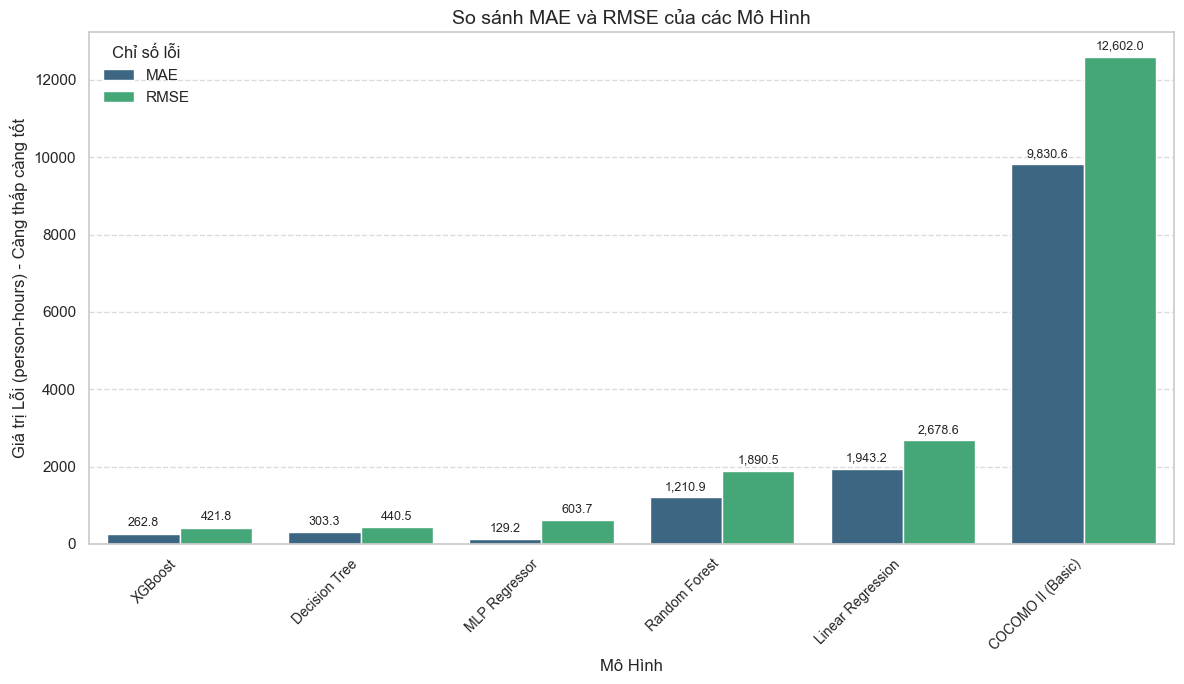


--- Bước 2.1: Vẽ Biểu Đồ So Sánh Hiệu Suất (R² Score) ---


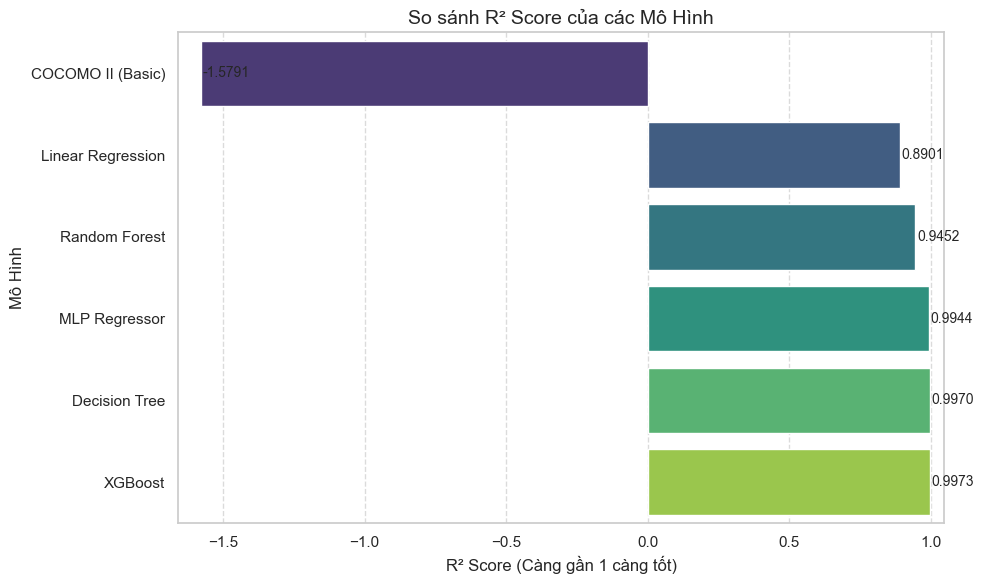


--- Bước 3: Phân Tích Kết Quả ---
Dựa trên Bảng Tổng Hợp và các Biểu đồ So sánh:

1. So sánh các mô hình Machine Learning (ML):
   - Mô hình 'XGBoost' cho RMSE thấp nhất (421.84 giờ).
   - Mô hình 'MLP Regressor' cho MAE thấp nhất (129.22 giờ).
   - Mô hình 'XGBoost' cho R² Score cao nhất (0.9973).
   -> Lưu ý: Mô hình tốt nhất có thể khác nhau tùy theo chỉ số đánh giá (RMSE, MAE, R²).
   - CẢNH BÁO QUAN TRỌNG: Như đã đề cập, các giá trị R² cực kỳ cao và MAE/RMSE rất thấp của các mô hình ML (đặc biệt là 'XGBoost') vẫn rất đáng ngờ do nghi vấn rò rỉ dữ liệu từ các đặc trưng gốc. Cần giải quyết vấn đề này trước khi kết luận về hiệu suất thực sự.

2. So sánh mô hình ML tốt nhất (ví dụ: 'XGBoost') với COCOMO II (cơ bản):
   - Mô hình ML tốt nhất cho sai số (MAE: 129.22, RMSE: 421.84) thấp hơn đáng kể và R² (0.9973) cao hơn nhiều so với COCOMO II cơ bản (MAE: 9830.61, RMSE: 12601.96, R²: -1.5791) trên bộ dữ liệu này.
   - Điều này nhấn mạnh hạn chế của COCOMO II cơ bản khi áp dụng các giả 

In [52]:
# -*- coding: utf-8 -*-
"""
Mục tiêu:
1. Tạo bảng tổng hợp kết quả (MAE, RMSE, R²) của tất cả các mô hình.
2. Vẽ biểu đồ cột nhóm so sánh MAE và RMSE của các mô hình.
3. Vẽ biểu đồ cột so sánh R² Score của các mô hình.
4. In ra phân tích, so sánh và đánh giá (bao gồm MAE, RMSE, R²).
5. In ra các đề xuất cải tiến.

Thư viện sử dụng: pandas, matplotlib, seaborn, numpy
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Quan trọng: Giả định các biến metrics sau đã tồn tại từ các cell trước ---
# mae_linear, rmse_linear, r2_linear (Prompt 2)
# mae_dt, rmse_dt, r2_dt (Prompt 3)
# mae_rf, rmse_rf, r2_rf (Prompt 4)
# mae_xgb, rmse_xgb, r2_xgb (Prompt 5, nếu đã chạy)
# mae_mlp, rmse_mlp, r2_mlp (Prompt 6, nếu đã chạy)
# mae_cocomo, rmse_cocomo, r2_cocomo (Prompt 7, nếu đã chạy)
# ---------------------------------------------------------------------------

print("--- Bước 1: Tạo Bảng Tổng Hợp Kết Quả ---")

# Tạo danh sách để lưu kết quả
model_results = []

# Kiểm tra và thêm kết quả từng mô hình
required_metrics_p8 = {
    'Linear Regression': ['mae_linear', 'rmse_linear', 'r2_linear'],
    'Decision Tree': ['mae_dt', 'rmse_dt', 'r2_dt'],
    'Random Forest': ['mae_rf', 'rmse_rf', 'r2_rf'],
    'XGBoost': ['mae_xgb', 'rmse_xgb', 'r2_xgb'],
    'MLP Regressor': ['mae_mlp', 'rmse_mlp', 'r2_mlp'],
    'COCOMO II (Basic)': ['mae_cocomo', 'rmse_cocomo', 'r2_cocomo']
}

for model_name, metrics in required_metrics_p8.items():
    # Kiểm tra xem tất cả metrics của model này có tồn tại không
    if all(metric in globals() for metric in metrics):
        model_results.append({
            'Model': model_name,
            'MAE': globals()[metrics[0]],
            'RMSE': globals()[metrics[1]],
            'R² Score': globals()[metrics[2]]
        })
    else:
        print(f"Thông báo: Không tìm thấy đủ metrics cho mô hình '{model_name}'. Bỏ qua.")

# Tạo DataFrame từ danh sách kết quả
if model_results:
    results_summary_df = pd.DataFrame(model_results)
    # Sắp xếp theo RMSE tăng dần (hoặc R2 giảm dần)
    results_summary_df = results_summary_df.sort_values(by='RMSE', ascending=True)

    print("\nBảng Tổng Hợp Kết Quả Đánh Giá Các Mô Hình:")
    # Sử dụng display để hiển thị DataFrame đẹp hơn
    from IPython.display import display
    display(results_summary_df.style.format({
        'MAE': '{:,.2f}',
        'RMSE': '{:,.2f}',
        'R² Score': '{:.4f}'
    }).hide(axis="index")) # Ẩn index cho gọn
else:
    print("\nLỖI: Không có đủ dữ liệu metrics để tạo bảng tổng hợp.")
    results_summary_df = pd.DataFrame() # Tạo DataFrame rỗng để code không lỗi ở bước sau

# --- Bước 2: Vẽ Biểu Đồ So Sánh Hiệu Suất (MAE & RMSE) ---
print("\n--- Bước 2: Vẽ Biểu Đồ So Sánh Hiệu Suất (MAE & RMSE) ---")

if not results_summary_df.empty and 'MAE' in results_summary_df.columns and 'RMSE' in results_summary_df.columns:
    # Chuẩn bị dữ liệu cho biểu đồ cột nhóm
    df_melted = results_summary_df[['Model', 'MAE', 'RMSE']].melt(
        id_vars='Model', var_name='Metric', value_name='Error Value'
    )
    model_order = results_summary_df.sort_values(by='RMSE', ascending=True)['Model'].tolist()

    plt.figure(figsize=(12, 7))
    ax_err = sns.barplot(x='Model', y='Error Value', hue='Metric', data=df_melted,
                         order=model_order, palette='viridis')

    plt.title('So sánh MAE và RMSE của các Mô Hình', fontsize=14)
    plt.xlabel('Mô Hình', fontsize=12)
    plt.ylabel('Giá trị Lỗi (person-hours) - Càng thấp càng tốt', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.legend(title='Chỉ số lỗi')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Thêm giá trị lỗi lên trên các cột
    try:
        for container in ax_err.containers:
            ax_err.bar_label(container, fmt='{:,.1f}', label_type='edge', padding=3, fontsize=9)
    except AttributeError:
         print("Cảnh báo: Không thể tự động thêm nhãn giá trị vào các cột lỗi (có thể do phiên bản thư viện cũ).")
    except Exception as e:
         print(f"Lỗi khi thêm nhãn giá trị lỗi: {e}")

    plt.tight_layout()
    plt.show()
else:
    print("Không có đủ dữ liệu MAE và RMSE để vẽ biểu đồ so sánh.")

# --- Bước 2.1: Vẽ Biểu Đồ So Sánh Hiệu Suất (R² Score) ---
# *** Thêm biểu đồ R² Score ***
print("\n--- Bước 2.1: Vẽ Biểu Đồ So Sánh Hiệu Suất (R² Score) ---")

if not results_summary_df.empty and 'R² Score' in results_summary_df.columns:
    plt.figure(figsize=(10, 6))
    # Sắp xếp lại theo R² tăng dần cho biểu đồ
    df_sorted_r2 = results_summary_df.sort_values(by='R² Score', ascending=True)

    # Sử dụng tên Model cho hue để mỗi thanh có màu riêng biệt
    ax_r2 = sns.barplot(x='R² Score', y='Model', data=df_sorted_r2, palette='viridis', hue='Model', dodge=False, legend=False)
    plt.title('So sánh R² Score của các Mô Hình', fontsize=14)
    plt.xlabel('R² Score (Càng gần 1 càng tốt)', fontsize=12)
    plt.ylabel('Mô Hình', fontsize=12)
    # Xác định giới hạn trục x hợp lý
    min_r2 = df_sorted_r2['R² Score'].min()
    max_r2 = df_sorted_r2['R² Score'].max()
    plt.xlim(min(0, min_r2 - 0.05 * abs(min_r2)), max(1.0, max_r2 + 0.05 * abs(max_r2))) # Đảm bảo trục x hợp lý

    # Thêm giá trị R² trên các thanh bar
    try:
         for bar in ax_r2.patches:
             ax_r2.text(bar.get_width() + 0.005,  # Vị trí x
                        bar.get_y() + bar.get_height() / 2, # Vị trí y
                        f'{bar.get_width():.4f}', # Giá trị R²
                        va='center', ha='left', fontsize=10)
    except Exception as e:
        print(f"Lỗi khi thêm nhãn giá trị R2: {e}")


    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Không có đủ dữ liệu R² Score để vẽ biểu đồ so sánh.")


# --- Bước 3: Phân Tích Kết Quả ---
# (Giữ nguyên phần phân tích, vì nó đã đề cập đến cả MAE/RMSE/R² dựa trên bảng)
print("\n--- Bước 3: Phân Tích Kết Quả ---")
print("Dựa trên Bảng Tổng Hợp và các Biểu đồ So sánh:") # Cập nhật text một chút

if not results_summary_df.empty:
    # Xác định mô hình tốt nhất theo từng chỉ số
    best_r2_model = results_summary_df.loc[results_summary_df['R² Score'].idxmax()]
    best_rmse_model = results_summary_df.loc[results_summary_df['RMSE'].idxmin()]
    best_mae_model = results_summary_df.loc[results_summary_df['MAE'].idxmin()]

    print(f"\n1. So sánh các mô hình Machine Learning (ML):")
    print(f"   - Mô hình '{best_rmse_model['Model']}' cho RMSE thấp nhất ({best_rmse_model['RMSE']:.2f} giờ).")
    print(f"   - Mô hình '{best_mae_model['Model']}' cho MAE thấp nhất ({best_mae_model['MAE']:.2f} giờ).")
    print(f"   - Mô hình '{best_r2_model['Model']}' cho R² Score cao nhất ({best_r2_model['R² Score']:.4f}).")
    # Nhận xét nếu mô hình tốt nhất khác nhau giữa các chỉ số
    if best_rmse_model['Model'] == best_mae_model['Model'] == best_r2_model['Model']:
         print(f"   -> Mô hình '{best_rmse_model['Model']}' thể hiện tốt nhất trên cả ba chỉ số chính.")
    else:
         print(f"   -> Lưu ý: Mô hình tốt nhất có thể khác nhau tùy theo chỉ số đánh giá (RMSE, MAE, R²).")

    print(f"   - CẢNH BÁO QUAN TRỌNG: Như đã đề cập, các giá trị R² cực kỳ cao và MAE/RMSE rất thấp của các mô hình ML (đặc biệt là '{best_rmse_model['Model']}') "
          f"vẫn rất đáng ngờ do nghi vấn rò rỉ dữ liệu từ các đặc trưng gốc. Cần giải quyết vấn đề này trước khi kết luận về hiệu suất thực sự.")

    if 'COCOMO II (Basic)' in results_summary_df['Model'].values:
        cocomo_results = results_summary_df[results_summary_df['Model'] == 'COCOMO II (Basic)'].iloc[0]
        print(f"\n2. So sánh mô hình ML tốt nhất (ví dụ: '{best_rmse_model['Model']}') với COCOMO II (cơ bản):")
        print(f"   - Mô hình ML tốt nhất cho sai số (MAE: {best_mae_model['MAE']:.2f}, RMSE: {best_rmse_model['RMSE']:.2f}) thấp hơn đáng kể "
              f"và R² ({best_r2_model['R² Score']:.4f}) cao hơn nhiều so với COCOMO II cơ bản "
              f"(MAE: {cocomo_results['MAE']:.2f}, RMSE: {cocomo_results['RMSE']:.2f}, R²: {cocomo_results['R² Score']:.4f}) trên bộ dữ liệu này.")
        print(f"   - Điều này nhấn mạnh hạn chế của COCOMO II cơ bản khi áp dụng các giả định chung và tiềm năng của ML (nếu dữ liệu đáng tin cậy).")
    else:
        print("\n2. Không có kết quả COCOMO II để so sánh.")

    print(f"\n3. Đánh giá chung:")
    print(f"   - Các mô hình ML cho thấy khả năng khớp với dữ liệu hiện có rất tốt (thể hiện qua MAE, RMSE thấp và R² cao).")
    print(f"   - Tuy nhiên, độ tin cậy của các kết quả này bị ảnh hưởng nghiêm trọng bởi nghi vấn rò rỉ dữ liệu. Cần ưu tiên giải quyết vấn đề này.")
    print(f"   - COCOMO II cơ bản cần được hiệu chỉnh cẩn thận với các tham số và hệ số phù hợp với môi trường cụ thể để có giá trị thực tế hơn.")

else:
    print("Không thể thực hiện phân tích do thiếu dữ liệu kết quả.")


# --- Bước 4: Đề xuất Cải tiến ---
# (Giữ nguyên các đề xuất như trước, vì chúng vẫn phù hợp)
print("\n--- Bước 4: Đề xuất Cải tiến ---")
print("Dựa trên các phân tích và kết quả quan sát được:")

print("\n1. **(Ưu tiên hàng đầu) Điều tra và Xử lý Rò rỉ Dữ liệu:**")
print("   - Xem xét lại kỹ lưỡng TẤT CẢ các cột trong dữ liệu gốc `dataset.csv`.")
print("   - Đặc biệt chú ý các cột như 'Team Size', 'Development Time (months)' hoặc bất kỳ cột nào có thể chứa thông tin chỉ biết được sau khi dự án kết thúc hoặc có tương quan quá cao với 'Effort'.")
print("   - Thử nghiệm loại bỏ các cột đáng ngờ này khỏi tập đặc trưng `X` ở Prompt 1 và chạy lại toàn bộ quy trình để xem kết quả có trở nên thực tế hơn không.")
print("   - Chỉ khi nào R² của các mô hình ML giảm xuống mức hợp lý (ví dụ: < 0.95), chúng ta mới có thể tin tưởng vào việc so sánh và lựa chọn mô hình.")

print("\n2. **Tinh chỉnh Siêu tham số Nâng cao (Sau khi xử lý leakage):**")
print("   - Khi đã có dữ liệu đáng tin cậy, sử dụng các kỹ thuật tìm kiếm siêu tham số mạnh mẽ hơn như `RandomizedSearchCV` (nhanh hơn GridSearchCV) hoặc Bayesian Optimization để tinh chỉnh mô hình ML tốt nhất (ví dụ: Random Forest, XGBoost).")

print("\n3. **Kỹ thuật Đặc trưng (Feature Engineering) (Sau khi xử lý leakage):**")
print("   - Tạo ra các đặc trưng mới từ các đặc trưng hiện có (ví dụ: tỷ lệ LOC/FP, tương tác giữa các biến) có thể giúp cải thiện mô hình.")
print("   - Áp dụng các phương pháp lựa chọn đặc trưng (feature selection) để loại bỏ các đặc trưng nhiễu hoặc không quan trọng sau khi đã xử lý leakage.")

print("\n4. **Hiệu chỉnh Mô hình COCOMO II:**")
print("   - Thay vì dùng công thức cơ bản với nhiều giả định, hãy nghiên cứu cách xác định Mô hình Dự án (Project Mode) phù hợp với loại hình dự án của bạn.")
print("   - Tìm hiểu và đánh giá các giá trị Effort Multipliers (EMs) thực tế cho môi trường phát triển của bạn để có ước tính COCOMO II chính xác hơn.")
print("   - Có thể sử dụng các công cụ phần mềm hỗ trợ tính toán COCOMO II đầy đủ.")

print("\n--- Hoàn thành (Biểu đồ MAE, RMSE, R²) ---")


In [56]:
# -*- coding: utf-8 -*-
"""
Script Python Hoàn Chỉnh: Huấn luyện và Lưu NHIỀU Model Dự đoán Effort
(Cập nhật: Tích hợp GridSearchCV cho Random Forest, RandomizedSearchCV cho MLPRegressor,
sử dụng RobustScaler, tăng max_iter cho MLP)
"""

import pandas as pd
import numpy as np
# Thêm import RandomizedSearchCV và các hàm phân phối
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform # Thêm import cho RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import argparse
import os
import warnings
from typing import Union, List, Dict, Any

# --- Cấu hình cơ bản ---
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
# Tạm thời bỏ qua ConvergenceWarning nếu muốn (thường gặp với MLP)
# Mặc dù chúng ta tăng max_iter, cảnh báo vẫn có thể xuất hiện cho một số kết hợp tham số tệ.
# Giữ lại bộ lọc này để tránh làm rối output.
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# --- Hàm Kiểm tra Dữ liệu ---
def validate_data(
    X_train: Union[np.ndarray, pd.DataFrame],
    X_test: Union[np.ndarray, pd.DataFrame],
    y_train: Union[np.ndarray, pd.Series],
    y_test: Union[np.ndarray, pd.Series]
) -> None:
    """Kiểm tra tính hợp lệ của dữ liệu đầu vào."""
    # (Code giữ nguyên như trước)
    # Kiểm tra dữ liệu trống
    if X_train.shape[0] == 0 or X_test.shape[0] == 0 or len(y_train) == 0 or len(y_test) == 0:
        raise ValueError("LỖI: Một hoặc nhiều tập dữ liệu trống.")

    # Kiểm tra kích thước phù hợp
    if X_train.shape[0] != len(y_train):
        raise ValueError(f"LỖI: Kích thước không khớp: X_train ({X_train.shape[0]}) và y_train ({len(y_train)}).")
    if X_test.shape[0] != len(y_test):
        raise ValueError(f"LỖI: Kích thước không khớp: X_test ({X_test.shape[0]}) và y_test ({len(y_test)}).")

    # Kiểm tra giá trị NaN/Infinite (Đã cập nhật để xử lý cả numpy và pandas)
    for data, name in [(X_train, "X_train"), (X_test, "X_test"), (y_train, "y_train"), (y_test, "y_test")]:
        is_nan = False
        is_inf = False
        if isinstance(data, (pd.DataFrame, pd.Series)):
            # Đối với DataFrame, kiểm tra NaN trên tất cả các cột
            if isinstance(data, pd.DataFrame):
                is_nan = data.isna().any().any()
                if np.issubdtype(data.values.dtype, np.number): # Chỉ kiểm tra inf nếu là số
                    is_inf = np.isinf(data.values).any()
            else: # Đối với Series
                is_nan = data.isna().any()
                if np.issubdtype(data.dtype, np.number):
                    is_inf = np.isinf(data.values).any()

        elif isinstance(data, np.ndarray):
            is_nan = np.isnan(data).any()
            if np.issubdtype(data.dtype, np.number):
                is_inf = np.isinf(data).any()

        if is_nan or is_inf:
            message_parts = []
            if is_nan: message_parts.append("NaN")
            if is_inf: message_parts.append("Infinite")
            raise ValueError(f"LỖI: {name} chứa giá trị {' hoặc '.join(message_parts)}.")


    # Kiểm tra kiểu dữ liệu target
    if not np.issubdtype(y_train.dtype, np.number) or not np.issubdtype(y_test.dtype, np.number):
        raise TypeError("LỖI: y_train hoặc y_test không phải kiểu số.")

    # Kiểm tra số lượng đặc trưng sau khi xử lý (nếu X là DataFrame)
    if isinstance(X_train, pd.DataFrame) and isinstance(X_test, pd.DataFrame):
        if X_train.shape[1] != X_test.shape[1]:
            raise ValueError(f"LỖI: Số đặc trưng không khớp sau tiền xử lý: X_train ({X_train.shape[1]}) và X_test ({X_test.shape[1]}).")
    # Trường hợp X là numpy array (cũng kiểm tra)
    elif isinstance(X_train, np.ndarray) and isinstance(X_test, np.ndarray):
        if X_train.shape[1] != X_test.shape[1]:
            raise ValueError(f"LỖI: Số đặc trưng không khớp sau tiền xử lý: X_train ({X_train.shape[1]}) và X_test ({X_test.shape[1]}).")


# --- Hàm Tải Dữ liệu ---
def load_data(file_path):
    """Tải dữ liệu từ file CSV."""
    # (Code giữ nguyên như trước)
    print(f"--- Đang tải dữ liệu từ: {file_path} ---")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"LỖI: Không tìm thấy file tại '{file_path}'")
    try:
        df = pd.read_csv(file_path)
        print(f"Tải dữ liệu thành công. Kích thước: {df.shape}")
        # Kiểm tra nhanh cột target
        if 'Effort (person-hours)' not in df.columns:
            print("CẢNH BÁO: Không tìm thấy cột 'Effort (person-hours)' trong CSV.")
        return df
    except Exception as e:
        raise IOError(f"Lỗi khi đọc file CSV '{file_path}': {e}")

# --- Hàm Tiền xử lý Dữ liệu ---
def preprocess_data(df):
    """Thực hiện tiền xử lý dữ liệu theo quy trình chuẩn chống rò rỉ."""
    # (Code giữ nguyên như trước)
    print("\n--- Bắt đầu Tiền xử lý Dữ liệu ---")
    target_col = 'Effort (person-hours)'
    id_col = 'Project ID'
    # Các cột có khả năng gây rò rỉ hoặc không dùng để dự đoán effort trực tiếp
    cols_to_drop_initial = ['Defect Density', 'Productivity', 'Schedule']
    if id_col in df.columns:
        cols_to_drop_initial.append(id_col)

    existing_cols_to_drop = [col for col in cols_to_drop_initial if col in df.columns]
    if existing_cols_to_drop:
        df_cleaned = df.drop(columns=existing_cols_to_drop)
        print(f"Đã loại bỏ các cột ban đầu: {', '.join(existing_cols_to_drop)}")
    else:
        df_cleaned = df.copy()
        print("Không có cột ban đầu nào cần loại bỏ.")

    if target_col not in df_cleaned.columns:
        raise ValueError(f"LỖI: Cột mục tiêu '{target_col}' không tồn tại trong dữ liệu sau khi làm sạch!")

    # Xử lý giá trị NaN/Infinite *trước khi* tách train/test để tránh lỗi sau này
    # Chỉ xử lý cột số cho Inf
    numeric_cols_check = df_cleaned.select_dtypes(include=np.number).columns
    if np.isinf(df_cleaned[numeric_cols_check]).any().any():
        print("CẢNH BÁO: Phát hiện giá trị Infinite trong cột số. Thay thế bằng NaN.")
        df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Kiểm tra NaN sau khi thay thế Inf
    if df_cleaned.isnull().any().any():
        print(f"Phát hiện giá trị NaN trong DataFrame.")
        # Cân nhắc: Có thể log cột nào bị NaN ở đây nếu cần debug
        # print(df_cleaned.isnull().sum())

    y = df_cleaned[target_col]
    X = df_cleaned.drop(columns=[target_col])
    print(f"Đã tách X ({X.shape}) và y ({y.shape}).")
    print(f"Các đặc trưng ban đầu trong X: {X.columns.tolist()}")

    # Tách dữ liệu TRƯỚC khi fit preprocessor để chống rò rỉ
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    print(f"Tách Train/Test: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}")

    # Xác định cột số và phân loại TỪ DỮ LIỆU HUẤN LUYỆN
    numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    print(f"Xác định từ X_train: {len(numerical_features)} cột số và {len(categorical_features)} cột phân loại.")
    print("  Cột số:", numerical_features)
    print("  Cột phân loại:", categorical_features)

    # Pipeline cho dữ liệu số: Impute NaN bằng median, sau đó Scale bằng RobustScaler
    numerical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])

    # Pipeline cho dữ liệu phân loại: Impute NaN bằng giá trị phổ biến nhất, sau đó OneHotEncode
    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        # drop='first' để tránh đa cộng tuyến, sparse_output=False để dễ dàng tạo DataFrame
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
    ])

    # Bộ tiền xử lý kết hợp cả hai pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numerical_features),
            ('cat', categorical_pipeline, categorical_features)
        ],
        remainder='passthrough', # Giữ lại các cột không được chỉ định (nếu có)
        verbose_feature_names_out=False # Giữ tên cột gốc cho phần số, và tên được tạo bởi OneHotEncoder
    )

    print("Fit preprocessor CHỈ trên X_train...")
    # Fit bộ tiền xử lý CHỈ trên dữ liệu huấn luyện
    preprocessor.fit(X_train)

    # Transform cả tập huấn luyện và tập kiểm thử
    print("Transform X_train và X_test...")
    X_train_processed_np = preprocessor.transform(X_train)
    X_test_processed_np = preprocessor.transform(X_test)

    # Lấy tên đặc trưng sau khi biến đổi (quan trọng cho việc diễn giải)
    try:
        # feature_names_out = preprocessor.get_feature_names_out(input_features=X_train.columns) # Nên truyền input_features
        # Sửa lỗi tiềm ẩn get_feature_names_out không cần input_features nếu dùng tên đơn giản
        feature_names_out = preprocessor.get_feature_names_out()
        print(f"Số lượng đặc trưng sau xử lý: {len(feature_names_out)}")
        # print("Tên đặc trưng sau xử lý:", feature_names_out) # In ra nếu cần debug
    except Exception as e:
        print(f"Lỗi khi lấy tên đặc trưng tự động: {e}. Sử dụng tên mặc định.")
        feature_names_out = [f'feature_{i}' for i in range(X_train_processed_np.shape[1])]

    # Tạo lại DataFrame với tên cột chính xác (giữ index gốc)
    X_train_processed = pd.DataFrame(X_train_processed_np, columns=feature_names_out, index=X_train.index)
    X_test_processed = pd.DataFrame(X_test_processed_np, columns=feature_names_out, index=X_test.index)

    # Kiểm tra dữ liệu lần cuối sau khi xử lý
    print("Kiểm tra dữ liệu sau tiền xử lý...")
    try:
        validate_data(X_train_processed, X_test_processed, y_train, y_test)
        print("Dữ liệu sau tiền xử lý hợp lệ.")
    except Exception as e:
        print(f"LỖI KIỂM TRA DỮ LIỆU SAU XỬ LÝ: {e}")
        # Quyết định xem có nên dừng lại ở đây hay không
        # raise # Bỏ comment nếu muốn dừng khi có lỗi nghiêm trọng

    print(f"Hoàn thành tiền xử lý. Kích thước cuối cùng: X_train={X_train_processed.shape}, X_test={X_test_processed.shape}")
    return X_train_processed, X_test_processed, y_train, y_test, preprocessor, feature_names_out


# --- Hàm Huấn luyện Mô hình ---
def train_single_model(model_type: str,
                       X_train: Union[np.ndarray, pd.DataFrame],
                       y_train: Union[np.ndarray, pd.Series],
                       params: Dict[str, Any] = None,
                       cv_folds: int = 5,
                       n_jobs: int = -1):
    """
    Huấn luyện một mô hình cụ thể.
    - Đối với Random Forest, thực hiện GridSearchCV nếu `params` chứa 'param_grid_rf'.
    - Đối với MLP Regressor, thực hiện RandomizedSearchCV nếu `params` chứa 'param_dist_mlp'.
    """
    print(f"\n--- Bắt đầu Huấn luyện Mô hình {model_type} ---")
    model = None # Khởi tạo model là None

    try:
        if model_type == 'Linear Regression':
            print("Sử dụng tham số mặc định.")
            model = LinearRegression(n_jobs=n_jobs) # Sử dụng n_jobs
            model.fit(X_train, y_train)

        elif model_type == 'Decision Tree':
            dt_params = params if params else {'max_depth': 7, 'random_state': 42}
            print("Sử dụng tham số:", dt_params)
            model = DecisionTreeRegressor(**dt_params)
            model.fit(X_train, y_train)

        elif model_type == 'Random Forest':
            # === TÍCH HỢP GRIDSEARCH CHO RANDOM FOREST ===
            # (Code giữ nguyên như trước)
            if not isinstance(params, dict) or 'param_grid_rf' not in params:
                raise ValueError("LỖI: Cần cung cấp 'param_grid_rf' dạng dict trong params cho Random Forest GridSearchCV.")

            param_grid_rf = params['param_grid_rf'] # Lấy param_grid từ params
            print("Thực hiện GridSearchCV cho Random Forest.")
            print("Không gian tham số tìm kiếm:", param_grid_rf)

            # Khởi tạo mô hình RF cơ sở
            rf_base = RandomForestRegressor(random_state=42, n_jobs=n_jobs)

            # Thiết lập GridSearchCV
            grid_search_rf = GridSearchCV(estimator=rf_base,
                                          param_grid=param_grid_rf,
                                          cv=cv_folds, # Sử dụng số folds từ tham số
                                          scoring='neg_mean_absolute_error', # Tối ưu theo MAE
                                          n_jobs=n_jobs, # Tận dụng CPU cores
                                          verbose=1) # Giảm verbose để bớt output

            print("Bắt đầu tìm kiếm tham số tốt nhất cho Random Forest...")
            grid_search_rf.fit(X_train, y_train)

            # Lấy ra mô hình tốt nhất từ GridSearch
            model = grid_search_rf.best_estimator_
            print(f"\nGridSearchCV hoàn thành.")
            print(f"Điểm MAE tốt nhất từ Cross-Validation: {-grid_search_rf.best_score_:.2f}")
            print("Tham số tốt nhất tìm thấy:", grid_search_rf.best_params_)


        elif model_type == 'XGBoost':
            # (Code giữ nguyên như trước)
            xgb_params = params if params else {
                'objective': 'reg:squarederror', 'n_estimators': 100, 'learning_rate': 0.1,
                'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.8,
                'random_state': 42
            }
            print("Sử dụng tham số:", xgb_params)
            # Truyền n_jobs vào đây khi khởi tạo
            model = xgb.XGBRegressor(**xgb_params, n_jobs=n_jobs)
            model.fit(X_train, y_train)


        # === TÍCH HỢP RANDOMIZEDSEARCH CHO MLP REGRESSOR (TỪ CODE 1) ===
        elif model_type == 'MLP Regressor':
            if not isinstance(params, dict) or 'param_dist_mlp' not in params:
                raise ValueError("LỖI: Cần cung cấp 'param_dist_mlp' dạng dict trong params cho MLP RandomizedSearchCV.")

            param_dist_mlp = params['param_dist_mlp']
            # Lấy các tham số cấu hình cho RandomizedSearch từ dict params (nếu có)
            n_iterations_search = params.get('n_iter_search', 15) # Số lần thử nghiệm tham số
            cv_search_folds = params.get('cv_search_folds', 3) # Số fold CV cho search
            scoring_metric = params.get('scoring', 'r2') # Chỉ số đánh giá cho search

            print("Thực hiện RandomizedSearchCV cho MLP Regressor.")
            print("Không gian phân phối tham số tìm kiếm:")
            for key, value in param_dist_mlp.items():
                print(f"  {key}: {value}")

            # Khởi tạo MLPRegressor cơ sở (với các tham số cố định)
            # *** TĂNG max_iter và n_iter_no_change ***
            mlp_base = MLPRegressor(random_state=42,
                                    max_iter=1500, # Tăng số lượt lặp tối đa
                                    early_stopping=True,
                                    validation_fraction=0.1,
                                    n_iter_no_change=20, # Tăng số lượt lặp không cải thiện trước khi dừng sớm
                                    verbose=False) # Giảm verbose trong base model

            # Khởi tạo RandomizedSearchCV
            random_search_mlp = RandomizedSearchCV(
                estimator=mlp_base,
                param_distributions=param_dist_mlp,
                n_iter=n_iterations_search,
                cv=cv_search_folds,
                scoring=scoring_metric,
                n_jobs=n_jobs,  # Sử dụng n_jobs từ tham số hàm
                random_state=42,
                verbose=1 # Giảm verbose để bớt output
            )

            print(f"\nBắt đầu RandomizedSearchCV với {n_iterations_search} lần thử và {cv_search_folds}-fold CV...")
            # Tìm kiếm trên dữ liệu huấn luyện ĐÃ XỬ LÝ CHUẨN
            random_search_mlp.fit(X_train, y_train)

            # Lấy ra mô hình và tham số tốt nhất
            model = random_search_mlp.best_estimator_ # Đây là mô hình MLP tốt nhất đã được huấn luyện lại
            print(f"\nRandomizedSearchCV hoàn thành.")
            print(f"Điểm {scoring_metric} tốt nhất từ Cross-Validation: {random_search_mlp.best_score_:.4f}")
            print("Đã tìm thấy bộ tham số tốt nhất:")
            print(random_search_mlp.best_params_)
            print("Mô hình MLP tốt nhất đã được huấn luyện lại trên toàn bộ tập train.")
            if hasattr(model, 'n_iter_'):
                 print(f"  Số vòng lặp thực tế của MLP cuối cùng: {model.n_iter_}")
        # === KẾT THÚC TÍCH HỢP RANDOMIZEDSEARCH ===

        else:
            raise ValueError(f"Loại mô hình không được hỗ trợ: {model_type}")

        if model: # Chỉ in nếu model được tạo thành công
            print(f"Huấn luyện mô hình {model_type} thành công.")
        return model

    except ImportError as ie:
        # Xử lý lỗi nếu thiếu thư viện như xgboost
        print(f"\nLỖI IMPORT khi huấn luyện {model_type}: {ie}")
        print("Hãy đảm bảo bạn đã cài đặt thư viện cần thiết (ví dụ: pip install xgboost scipy).")
        return None # Trả về None để vòng lặp chính có thể bỏ qua mô hình này
    except Exception as e:
        print(f"LỖI không xác định khi huấn luyện mô hình {model_type}: {e}")
        # Xem xét việc ghi log lỗi chi tiết ở đây nếu cần
        # import traceback
        # traceback.print_exc()
        raise # Ném lại lỗi để dừng script nếu cần

# --- Hàm Đánh giá Mô hình ---
def evaluate_model(model, X_test, y_test, model_name="Mô hình", output_dir="."):
    """Đánh giá mô hình trên tập kiểm thử và vẽ/lưu biểu đồ."""
    # (Code giữ nguyên như trước)
    print(f"\n--- Đánh giá {model_name} trên Tập Test ---")
    if model is None:
        print(f"Mô hình {model_name} không có sẵn để đánh giá (có thể do lỗi huấn luyện).")
        return None # Trả về None nếu mô hình không hợp lệ

    try:
        y_pred = model.predict(X_test)

        # Kiểm tra dự đoán NaN/Infinite
        if np.isnan(y_pred).any() or np.isinf(y_pred).any():
            num_nan = np.isnan(y_pred).sum()
            num_inf = np.isinf(y_pred).sum()
            print(f"CẢNH BÁO: Dự đoán từ {model_name} chứa {num_nan} NaN và {num_inf} Infinite. Đánh giá có thể không chính xác.")
            # Quyết định cách xử lý: có thể thay thế bằng giá trị nào đó hoặc bỏ qua đánh giá
            # Ví dụ: thay NaN/Inf bằng giá trị trung bình của y_test (không lý tưởng nhưng tránh lỗi)
            # y_pred = np.nan_to_num(y_pred, nan=y_test.mean(), posinf=y_test.max(), neginf=y_test.min())
            # Hoặc đơn giản là báo cáo lỗi và trả về None
            return None


        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"Mean Absolute Error (MAE): {mae:.2f} person-hours")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f} person-hours")
        print(f"R² Score: {r2:.4f}")

        # Tạo thư mục đầu ra nếu chưa tồn tại
        if not os.path.exists(output_dir):
            print(f"Tạo thư mục lưu biểu đồ: {output_dir}")
            os.makedirs(output_dir)

        # Vẽ và lưu biểu đồ
        print(f"Đang tạo biểu đồ đánh giá cho {model_name}...")
        plot_suffix = model_name.lower().replace(' ', '_').replace('(', '').replace(')', '')

        # 1. Biểu đồ Scatter: Thực tế vs Dự đoán
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='w', s=60)
        max_val = max(y_test.max(), y_pred.max()) if not y_test.empty else 0
        min_val = min(y_test.min(), y_pred.min()) if not y_test.empty else 0
        plot_min = min_val - (max_val - min_val) * 0.1 if max_val > min_val else min_val - 1
        plot_max = max_val + (max_val - min_val) * 0.1 if max_val > min_val else max_val + 1
        plt.plot([plot_min, plot_max], [plot_min, plot_max], 'r--', lw=2, label='Đường y=x (Lý tưởng)')
        plt.xlabel('Effort Thực tế (person-hours)', fontsize=11)
        plt.ylabel('Effort Dự đoán (person-hours)', fontsize=11)
        plt.title(f'{model_name}: Thực tế vs. Dự đoán', fontsize=13)
        plt.xlim(plot_min, plot_max)
        plt.ylim(plot_min, plot_max)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        scatter_filename = os.path.join(output_dir, f"{plot_suffix}_scatter.png")
        try:
            plt.savefig(scatter_filename)
            print(f"Đã lưu: {scatter_filename}")
        except Exception as e:
            print(f"LỖI khi lưu biểu đồ scatter {model_name}: {e}")
        plt.close() # Đóng plot để giải phóng bộ nhớ

        # 2. Biểu đồ Residual: Phần dư vs Dự đoán
        residuals = y_test - y_pred
        plt.figure(figsize=(8, 5))
        plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='w', s=60)
        plt.axhline(y=0, color='r', linestyle='--', lw=2)
        plt.xlabel('Effort Dự đoán (person-hours)', fontsize=11)
        plt.ylabel('Phần dư (Thực tế - Dự đoán)', fontsize=11)
        plt.title(f'{model_name}: Biểu đồ Phần dư', fontsize=13)
        plt.grid(True, linestyle='--', alpha=0.6)
        residual_filename = os.path.join(output_dir, f"{plot_suffix}_residuals.png")
        try:
            plt.savefig(residual_filename)
            print(f"Đã lưu: {residual_filename}")
        except Exception as e:
            print(f"LỖI khi lưu biểu đồ residual {model_name}: {e}")
        plt.close() # Đóng plot

        return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R² Score': r2}

    except Exception as e:
        print(f"LỖI không xác định khi đánh giá mô hình {model_name}: {e}")
        # import traceback
        # traceback.print_exc() # In chi tiết lỗi nếu cần debug
        return None # Trả về None nếu có lỗi nghiêm trọng trong đánh giá


# --- Hàm Chính ---
def main(args):
    """Hàm chính điều khiển luồng thực thi của script."""
    # (Code giữ nguyên như trước)
    try:
        df = load_data(args.input_csv)
        X_train_processed, X_test_processed, y_train, y_test, preprocessor, feature_names_out = preprocess_data(df)
    except FileNotFoundError as e:
        print(e)
        return # Dừng script nếu không tìm thấy file
    except ValueError as e:
        print(f"LỖI DỮ LIỆU: {e}")
        return # Dừng script nếu dữ liệu có vấn đề nghiêm trọng
    except IOError as e:
        print(f"LỖI ĐỌC FILE: {e}")
        return
    except Exception as e:
        print(f"LỖI không mong muốn trong quá trình tải/tiền xử lý: {e}")
        # import traceback
        # traceback.print_exc()
        return


    # === ĐỊNH NGHĨA CÁC MÔ HÌNH VÀ THAM SỐ ===
    model_configs = {
        'Linear Regression': {}, # Tham số mặc định
        'Decision Tree': {'max_depth': 7, 'min_samples_leaf': 5, 'random_state': 42}, # Thêm min_samples_leaf
        'Random Forest': { # Tham số cho GridSearchCV
            'param_grid_rf': { # Đặt param_grid vào trong một key riêng
                'n_estimators': [100, 150],       # Giảm số lượng để chạy nhanh hơn
                'max_depth': [10, 15, None],      # Giảm số lượng để chạy nhanh hơn
                'min_samples_leaf': [1, 3],       # Giảm số lượng
                'min_samples_split': [2, 5],
                'max_features': ['sqrt', 'log2']
            }
            # cv_folds và n_jobs sẽ được truyền vào train_single_model
        },
        'XGBoost': { # Tham số cho XGBoost
            'objective': 'reg:squarederror', 'n_estimators': 150, 'learning_rate': 0.08,
            'max_depth': 6, 'subsample': 0.7, 'colsample_bytree': 0.7,
            'random_state': 42
            # n_jobs sẽ được thêm trong train_single_model
        },
        'MLP Regressor': { # *** THAM SỐ CHO RANDOMIZEDSEARCHCV ***
            'param_dist_mlp': { # Đặt không gian phân phối vào key riêng
                'hidden_layer_sizes': [(50,), (100,), (50, 30), (100, 50), (128, 64), (64, 32)],
                'activation': ['relu', 'tanh'],
                'solver': ['adam'],
                'alpha': loguniform(1e-5, 1e-1),
                'learning_rate': ['constant', 'adaptive'],
                'learning_rate_init': loguniform(1e-4, 1e-2),
                'batch_size': [32, 64, 128],
            },
            'n_iter_search': 15, # Số lần thử nghiệm cho RandomizedSearch (có thể điều chỉnh)
            'cv_search_folds': 3, # Số fold CV cho RandomizedSearch (có thể điều chỉnh)
            'scoring': 'r2'      # Chỉ số đánh giá cho RandomizedSearch
            # Các tham số cố định như random_state, max_iter, early_stopping được đặt trong mlp_base bên trong train_single_model
        }
    }

    trained_models = {}
    evaluation_results = []
    # Có thể điều chỉnh n_jobs và cv_folds mặc định ở đây nếu cần
    n_jobs_train = -1 # Sử dụng tất cả CPU cores có sẵn cho việc huấn luyện (-1)
    cv_folds_grid_search = 5 # Số fold mặc định cho GridSearchCV (RF)

    # Xác định thư mục lưu kết quả
    output_dir = "."
    if args.preprocessor_output:
        output_dir = os.path.dirname(args.preprocessor_output)
    elif args.features_output:
        output_dir = os.path.dirname(args.features_output)
    elif args.model_output: # Sử dụng model_output làm fallback
        output_dir = os.path.dirname(args.model_output)

    # Đảm bảo output_dir không rỗng và tồn tại
    if not output_dir: output_dir = "."
    if output_dir == "": output_dir = "." # Xử lý trường hợp dirname trả về chuỗi rỗng

    if output_dir != "." and not os.path.exists(output_dir):
        print(f"Tạo thư mục đầu ra: {output_dir}")
        os.makedirs(output_dir)

    # --- Vòng lặp Huấn luyện và Đánh giá ---
    for model_name, config_params in model_configs.items():
        try:
            # Xác định số fold CV phù hợp cho mô hình hiện tại
            # Chỉ RF dùng GridSearchCV với cv_folds_grid_search
            # MLP dùng RandomizedSearchCV với cv_search_folds (đã lấy từ config)
            current_cv_folds = cv_folds_grid_search if model_name == 'Random Forest' else 5 # Mặc định cho các model khác

            model = train_single_model(model_name, X_train_processed, y_train,
                                       params=config_params, # Truyền toàn bộ dict config
                                       cv_folds=current_cv_folds, # Số fold cho GridSearch (RF)
                                       n_jobs=n_jobs_train)

            if model: # Chỉ đánh giá nếu huấn luyện thành công
                trained_models[model_name] = model
                # Truyền output_dir vào hàm evaluate để lưu biểu đồ đúng chỗ
                results = evaluate_model(model, X_test_processed, y_test,
                                         model_name=model_name,
                                         output_dir=output_dir)
                if results: # Chỉ thêm kết quả nếu đánh giá thành công
                    evaluation_results.append(results)
            else:
                print(f"Bỏ qua đánh giá cho {model_name} do lỗi huấn luyện hoặc thiếu thư viện.")

        except Exception as e:
            print(f"\nLỖI không mong muốn trong vòng lặp chính cho mô hình {model_name}: {e}")
            # import traceback
            # traceback.print_exc() # In chi tiết lỗi để debug
            # Cân nhắc xem có nên tiếp tục với mô hình tiếp theo hay dừng lại
            # continue # Bỏ comment để tiếp tục với mô hình khác nếu có lỗi

    # --- Tổng hợp và Hiển thị Kết quả ---
    # (Code giữ nguyên như trước)
    if evaluation_results:
        summary_df = pd.DataFrame(evaluation_results).sort_values(by='RMSE', ascending=True)
        print("\n--- Bảng Tổng Hợp Kết Quả Đánh Giá (Sắp xếp theo RMSE tăng dần) ---")
        try:
            from IPython.display import display
            # Định dạng số cho dễ đọc và ẩn index
            display(summary_df.style.format({
                'MAE': '{:,.2f}'.format,
                'RMSE': '{:,.2f}'.format,
                'R² Score': '{:.4f}'.format
            }).hide(axis="index"))
        except ImportError:
            # In ra console nếu không trong môi trường có IPython.display
            print(summary_df.to_string(index=False,
                                        float_format=lambda x: f'{x:,.2f}' if pd.Series([x]).name in ['MAE', 'RMSE'] else f'{x:.4f}'))

        # Lưu bảng tổng hợp vào file CSV
        summary_filename = os.path.join(output_dir, "model_evaluation_summary.csv")
        try:
            summary_df.to_csv(summary_filename, index=False, float_format='%.4f')
            print(f"\nĐã lưu bảng tổng hợp kết quả vào: {summary_filename}")
        except Exception as e:
            print(f"LỖI khi lưu bảng tổng hợp: {e}")

    else:
        print("\nKhông có kết quả đánh giá nào để hiển thị hoặc lưu.")


    # --- Trực quan hóa Độ quan trọng Đặc trưng cho Random Forest và XGBoost ---
    # (Code giữ nguyên như trước)
    for model_key, model_display_name in [('Random Forest', 'Random Forest'), ('XGBoost', 'XGBoost')]:
        if model_key in trained_models:
            print(f"\n--- Phân tích Độ quan trọng Đặc trưng ({model_display_name}) ---")
            model_final = trained_models[model_key]
            importances = None
            if hasattr(model_final, 'feature_importances_'): # RF, XGBoost (sklearn API)
                 importances = model_final.feature_importances_
            # elif hasattr(model_final, 'get_booster'): # XGBoost native API (ít dùng hơn khi tích hợp sklearn)
            #     try:
            #         importance_dict = model_final.get_booster().get_score(importance_type='weight')
            #         # Cần ánh xạ lại tên đặc trưng nếu dùng native API và tên mặc định f0, f1...
            #         # Đoạn này phức tạp hơn, tạm thời dựa vào feature_importances_
            #     except Exception as e:
            #         print(f"Không thể lấy độ quan trọng từ XGBoost native API: {e}")

            if importances is not None:
                 # Kiểm tra xem feature_names_out có tồn tại và khớp kích thước không
                if 'feature_names_out' in locals() and len(feature_names_out) == len(importances):
                    feature_importance_df = pd.DataFrame({'Feature': feature_names_out, 'Importance': importances})
                    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

                    top_n = 20 # Số lượng đặc trưng hàng đầu muốn hiển thị
                    feature_importance_df_top = feature_importance_df.head(top_n)

                    print(f"Top {top_n} đặc trưng quan trọng nhất ({model_display_name}):")
                    print(feature_importance_df_top.to_string(index=False))

                    # Vẽ biểu đồ độ quan trọng
                    plt.figure(figsize=(10, max(6, top_n * 0.35))) # Điều chỉnh kích thước dựa trên top_n
                    sns.barplot(x='Importance', y='Feature', data=feature_importance_df_top,
                                palette='viridis', hue='Feature', dodge=False, legend=False)
                    plt.title(f'Top {top_n} Đặc trưng Quan trọng Nhất ({model_display_name})', fontsize=14)
                    plt.xlabel('Độ quan trọng (Importance Score)', fontsize=12)
                    plt.ylabel('Đặc trưng (Feature)', fontsize=12)
                    plt.grid(axis='x', linestyle='--', alpha=0.6)
                    plt.tight_layout() # Tự động điều chỉnh layout

                    # Lưu biểu đồ
                    plot_suffix = model_key.lower().replace(' ', '_')
                    importance_filename = os.path.join(output_dir, f"{plot_suffix}_feature_importance.png")
                    try:
                        plt.savefig(importance_filename)
                        print(f"\nĐã lưu biểu đồ độ quan trọng {model_display_name} vào: {importance_filename}")
                    except Exception as e:
                        print(f"LỖI khi lưu biểu đồ độ quan trọng {model_display_name}: {e}")
                    plt.close() # Đóng plot
                else:
                    print(f"CẢNH BÁO ({model_display_name}): Không thể tạo biểu đồ độ quan trọng do thiếu tên đặc trưng hoặc không khớp số lượng.")
                    print(f"  Số lượng importances: {len(importances)}")
                    if 'feature_names_out' in locals():
                        print(f"  Số lượng feature_names_out: {len(feature_names_out)}")
                    else:
                        print("  feature_names_out không tồn tại.")
            else:
                 print(f"Mô hình {model_display_name} được huấn luyện không có thuộc tính 'feature_importances_'.")
        else:
             print(f"\nKhông có mô hình {model_display_name} nào được huấn luyện thành công để phân tích độ quan trọng.")



    # --- Lưu các Đối tượng Cần Thiết ---
    # (Code giữ nguyên như trước)
    print("\n--- Lưu Preprocessor, Tên Đặc trưng và Các Mô hình ---")

    # Lưu Preprocessor
    if 'preprocessor' in locals() and args.preprocessor_output:
        try:
            joblib.dump(preprocessor, args.preprocessor_output)
            print(f"Đã lưu preprocessor vào: {args.preprocessor_output}")
        except Exception as e:
            print(f"LỖI khi lưu preprocessor vào '{args.preprocessor_output}': {e}")
    elif not args.preprocessor_output:
        print("Không có đường dẫn preprocessor_output được cung cấp, bỏ qua lưu preprocessor.")
    else:
        print("Preprocessor không tồn tại, không thể lưu.")


    # Lưu Tên Đặc trưng
    if 'feature_names_out' in locals() and args.features_output:
        try:
            joblib.dump(feature_names_out, args.features_output)
            print(f"Đã lưu danh sách tên đặc trưng vào: {args.features_output}")
        except Exception as e:
            print(f"LỖI khi lưu tên đặc trưng vào '{args.features_output}': {e}")
    elif not args.features_output:
        print("Không có đường dẫn features_output được cung cấp, bỏ qua lưu tên đặc trưng.")
    else:
        print("Danh sách tên đặc trưng (feature_names_out) không tồn tại, không thể lưu.")


    # Lưu các Mô hình đã Huấn luyện
    if trained_models:
        print("Đang lưu các mô hình đã huấn luyện...")
        for model_name, model_object in trained_models.items():
            # Tạo tên file chuẩn hóa từ tên mô hình
            model_filename = f"{model_name.lower().replace(' ', '_').replace('(', '').replace(')', '')}_model.joblib"
            model_save_path = os.path.join(output_dir, model_filename)
            try:
                joblib.dump(model_object, model_save_path)
                print(f"  Đã lưu mô hình {model_name} vào: {model_save_path}")
            except Exception as e:
                print(f"  LỖI khi lưu mô hình {model_name} vào '{model_save_path}': {e}")
    else:
        print("Không có mô hình nào được huấn luyện thành công để lưu.")


# Tạo đối tượng args giả lập
class Args:
    input_csv = 'dataset.csv' # !!! Đặt đường dẫn ĐÚNG đến file CSV của bạn ở đây !!!
    model_output = "effort_model.joblib"
    preprocessor_output = "preprocessor.joblib"
    features_output = "feature_names.joblib"

# Tạo một instance của class Args
mock_args = Args()

# Gọi hàm main với đối tượng args giả lập
try:
    main(mock_args)
except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"Đã xảy ra lỗi không mong muốn: {e}")
    # Nếu muốn xem chi tiết lỗi đầy đủ trong Jupyter, dùng:
    # %tb
# --- Điểm Bắt đầu Thực thi Script ---
    print("\n--- Script Hoàn Thành ---")


--- Đang tải dữ liệu từ: dataset.csv ---
Tải dữ liệu thành công. Kích thước: (10000, 17)

--- Bắt đầu Tiền xử lý Dữ liệu ---
Đã loại bỏ các cột ban đầu: Defect Density, Productivity, Schedule, Project ID
Đã tách X ((10000, 12)) và y ((10000,)).
Các đặc trưng ban đầu trong X: ['LOC', 'FP', 'UCP', 'Development Time (months)', 'Team Size', 'Project Type', 'Language Type', 'Primary Programming Language', 'Count Approach', 'Application Group', 'Application Type', 'Development Type']
Tách Train/Test: X_train=(8000, 12), X_test=(2000, 12), y_train=(8000,), y_test=(2000,)
Xác định từ X_train: 5 cột số và 7 cột phân loại.
  Cột số: ['LOC', 'FP', 'UCP', 'Development Time (months)', 'Team Size']
  Cột phân loại: ['Project Type', 'Language Type', 'Primary Programming Language', 'Count Approach', 'Application Group', 'Application Type', 'Development Type']
Fit preprocessor CHỈ trên X_train...
Transform X_train và X_test...
Số lượng đặc trưng sau xử lý: 38
Kiểm tra dữ liệu sau tiền xử lý...
Dữ liệu 

Model,MAE,RMSE,R² Score
XGBoost,262.83,421.84,0.9973
Decision Tree,303.31,440.50,0.9970
MLP Regressor,125.60,577.08,0.9949
Random Forest,"1,233.42","1,922.60",0.9434
Linear Regression,"1,943.18","2,678.59",0.8901



Đã lưu bảng tổng hợp kết quả vào: .\model_evaluation_summary.csv

--- Phân tích Độ quan trọng Đặc trưng (Random Forest) ---
Top 20 đặc trưng quan trọng nhất (Random Forest):
                                               Feature  Importance
                                             Team Size    0.390216
                             Development Time (months)    0.295636
                               Project Type_Enterprise    0.054698
                                      Project Type_Web    0.051490
                                                   LOC    0.029118
                                                   UCP    0.027804
                                                    FP    0.026653
                                   Project Type_Mobile    0.023728
                                     Language Type_4GL    0.012528
               Application Group_Real-Time Application    0.004333
                                  Count Approach_FiSMA    0.004261
Application Group_Mat